# BERT hierarchical multi-class classification model Creation 

In [1]:
# Imports 
import pandas as pd
import re
import torch
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

## Dataset Creation & Cleaning Functions 

In [2]:
# Get Dataset from FILE_PATH, use CALS as headers 
def get_dataset(FILE_PATH, COLS):
    df = pd.read_csv(FILE_PATH, names=COLS, index_col=False)
    df.head() 
    return df

### Data Cleaning Functions

In [3]:
# Clean Text function - use reges to remove non alphanumeric characters, remove common key words from data source 
def clean_text(text):
    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)

    # Remove specified words
    words_to_remove = ['tesco', 'tescos', 'sainsbury', 'sainsburys']
    pattern = re.compile(r'\b(' + '|'.join(words_to_remove) + r')\b', re.IGNORECASE)
    text = pattern.sub("", text)

    # Remove extra spaces
    text = ' '.join(text.split())

    return text

In [4]:
# Remove quantity based text, remove common quantaties 
def remove_quantities(text):
    # Remove quantities like '4 pack', '500g', '1kg', etc.
    pattern = r"\b\d+\s*(pack|g|kg|ml|l|oz|lb)\b"
    text_without_quantities = re.sub(pattern, "", text, flags=re.IGNORECASE)
    
    # Remove standalone numbers
    pattern = r"\b\d+\b"
    text_without_quantities = re.sub(pattern, "", text_without_quantities)
    
    return text_without_quantities

## Pre-Processing Functions

In [5]:
# Encoding Labels, returns the label dictionary 
def encode_labels(df):
    possible_labels = df.CATEGORY.unique()
    label_dict = {}
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index
    print(label_dict)
    return possible_labels, label_dict

## Train Test Split 

In [6]:
# Train test split, edits dataframe. Randomizes data.
def tts_df(df):
    df = df.sample(frac=1, random_state=42)

    x_train, x_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.2,
        random_state=42,
        stratify=df.label.values
    )

    df['data_type'] = ['not_set']*df.shape[0]

    df.loc[x_train, 'data_type'] = 'train'
    df.loc[x_val, 'data_type'] = 'val'

    df.groupby(['CATEGORY', 'label', 'data_type']).count()

    return df, x_train, x_val, y_train, y_val

## Tokenization 

In [7]:
# Tokenizes and inputted dataframe, returns 2 TensorDatasets for training and validation
def tokenize_df(df):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                            do_lower_case=True)

    encoded_data_train = tokenizer.batch_encode_plus(
        df[df.data_type=='train'].NAME.values,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=512,
        return_tensors='pt',
    )


    encoded_data_val = tokenizer.batch_encode_plus(
        df[df.data_type=='val'].NAME.values, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        pad_to_max_length=True, 
        max_length=256, 
        return_tensors='pt'
    )

    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(df[df.data_type=='train'].label.values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(df[df.data_type=='val'].label.values)

    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

    return dataset_train, dataset_val



## Pre-training and Training Functions

In [8]:
# Performance Metrics 

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels, label_dict):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [9]:
def evaluate(dataloader_val, model, device):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    true_probs, predicted_probs = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        true_probs.append(label_ids.flatten())
        predicted_probs.append(logits)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    true_probs = np.concatenate(true_probs, axis=0)
    predicted_probs = np.concatenate(predicted_probs, axis=0)
            
    return loss_val_avg, predictions, true_vals, true_probs, predicted_probs


## Training 

In [10]:
def training_loop(model, epochs, dataloader_train, dataloader_validation, device, optimizer, scheduler, SAVE_PATH):
    training_stats = []
    for epoch in tqdm(range(1, epochs+1)):
        
        model.train()
        
        loss_train_total = 0
        correct_train_total = 0
        total_train_samples = 0

        progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
        for batch in progress_bar:

            model.zero_grad()
            
            batch = tuple(b.to(device) for b in batch)
            
            inputs = {'input_ids':      batch[0],
                    'attention_mask': batch[1],
                    'labels':         batch[2],
                    }       

            outputs = model(**inputs)
            
            loss = outputs[0]
            logits = outputs[1]
            loss_train_total += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            # Calculate accuracy
            preds = torch.argmax(logits, dim=1)
            correct_train_total += (preds == inputs['labels']).sum().item()
            total_train_samples += inputs['labels'].size(0)
            
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
            
        torch.save(model.state_dict(), f'{SAVE_PATH}/finetuned_BERT_epoch_{epoch}.model')
            
        tqdm.write(f'\nEpoch {epoch}')
        
        loss_train_avg = loss_train_total/len(dataloader_train)            
        tqdm.write(f'Training loss: {loss_train_avg}')
        
        val_loss, predictions, true_vals, preds_flat, true_probs = evaluate(dataloader_validation, model, device)
        val_f1 = f1_score_func(predictions, true_vals)
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (Weighted): {val_f1}')
        train_accuracy = correct_train_total / total_train_samples
        training_stats.append({
            'epoch': epoch,
            'Training Loss': loss_train_avg,
            'Valid. Loss': val_loss,
            'Training Accur.': train_accuracy,  # You will need to calculate the training accuracy
            'Valid. Accur.': val_f1,
        })
    return training_stats

## Testing 

In [11]:
def load_test(label_dict, device, dataloader_validation, SAVE_PATH):
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels=len(label_dict),
                                                        output_attentions=False,
                                                        output_hidden_states=False)

    model.to(device)

    model.load_state_dict(torch.load(f'{SAVE_PATH}/finetuned_BERT_epoch_4.model', map_location=torch.device('cuda')))

    val_loss, predictions, true_vals, preds_flat, true_probs = evaluate(dataloader_validation, model=model, device=device)
    accuracy_per_class(predictions, true_vals, label_dict)
    return val_loss, predictions, true_vals, preds_flat, true_probs

## Data Visualisation Functions

In [12]:
## Confusion Matrix 
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

In [13]:
def plot_bar_charts(training_stats):
    df_stats = pd.DataFrame(training_stats)
    df_stats = df_stats.set_index('epoch')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    ax1.plot(df_stats['Training Loss'], label="Training Loss")
    ax1.plot(df_stats['Valid. Loss'], label="Validation Loss")
    ax1.set_title("Loss Curve")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(df_stats['Training Accur.'], label="Training Accuracy")
    ax2.plot(df_stats['Valid. Accur.'], label="Validation Accuracy")
    ax2.set_title("Accuracy Curve")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.show()


In [14]:

def plot_roc_auc(y_true, y_pred, true_probs, predicted_probs, label_names):
    n_classes = len(label_names)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_probs[:, i], predicted_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label_names[i]} (area = {roc_auc[i]:.2f}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()


# Model Training Loop

In [15]:
## Full training Loop
from scipy.special import softmax


def model_trainer(DATA_SET_PATH, SAVE_PATH, COLS, BATCH_SIZE, EPOCHS, MODEL_NAME, DROPOUT_RATE, LEARNING_RATE, WEIGHT_DECAY, GRADIENT_CLIPPING):
    # Get Dataset
    print(f'Opening Dataset of Model: {MODEL_NAME}')
    df = get_dataset(DATA_SET_PATH, COLS)
    
    # Clean Dataset
    print(f'Cleaning Dataset of Model: {MODEL_NAME}')
    df['NAME'] = df['NAME'].apply(clean_text)
    df['NAME'] = df['NAME'].apply(remove_quantities)
    df['NAME'] = df['NAME'].str.replace('\d', '', regex=True)

    # Encoding labels
    print(f'Encoding Labels of Model: {MODEL_NAME}')
    possible_labels, label_dict = encode_labels(df)
    df['label'] = df.CATEGORY.replace(label_dict)

    # Train Test split
    print(f'Splitting Data of Model: {MODEL_NAME}')
    df, x_train, x_val, y_train, y_val = tts_df(df)

    # Tokenization 
    print(f'Tokenizing: {MODEL_NAME}')
    dataset_train, dataset_val = tokenize_df(df)

    # Create Model from pre-made bert 
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                        num_labels=len(label_dict),
                                                        output_attentions=False,
                                                        output_hidden_states=False,
                                                        hidden_dropout_prob=DROPOUT_RATE
                                                        )
    
    ## Loading data 
    print(f'Loading Data of Model: {MODEL_NAME}')
    dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=BATCH_SIZE)

    dataloader_validation = DataLoader(dataset_val, 
                                    sampler=SequentialSampler(dataset_val), 
                                    batch_size=BATCH_SIZE)
    
    ## Optimizer & Schedular 
    optimizer = AdamW(model.parameters(),
                  lr=LEARNING_RATE, 
                  eps=1e-8,
                  weight_decay=WEIGHT_DECAY,
                  )

    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=0,
                                                num_training_steps=len(dataloader_train)*EPOCHS)

    ## Cuda Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model.to(device)
    torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIPPING)
    seed_val = 17
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    print(f'Training of Model: {MODEL_NAME}')
    training_stats = training_loop(epochs=EPOCHS, dataloader_train=dataloader_train,
                  dataloader_validation=dataloader_validation,
                  device=device, optimizer=optimizer,
                  scheduler=scheduler, SAVE_PATH=SAVE_PATH,
                  model=model
                  )
    
    print(f'Testing Model: {MODEL_NAME}')
    val_loss, predictions, true_vals, y_true, y_pred = load_test(label_dict=label_dict,
              device=device,
              dataloader_validation=dataloader_validation,
              SAVE_PATH=SAVE_PATH
              )
    y_pred_labels = np.argmax(y_pred, axis=1)

    plot_confusion_matrix(y_true, y_pred_labels, list(label_dict.keys()))
    plot_bar_charts(training_stats)
    
    y_true_probs = np.eye(len(label_dict))[y_true]
    y_pred_probs = softmax(predictions, axis=1)
    
    plot_roc_auc(y_true, y_pred, y_true_probs, y_pred_probs, list(label_dict.keys()))

Opening Dataset of Model: Food And Beverage Classifier
Cleaning Dataset of Model: Food And Beverage Classifier
Encoding Labels of Model: Food And Beverage Classifier
{'FDAA': 0, 'BEVA': 1}
Splitting Data of Model: Food And Beverage Classifier
Tokenizing: Food And Beverage Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: Food And Beverage Classifier
Using device: cuda
Training of Model: Food And Beverage Classifier


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.21542116888868726
Validation loss: 0.13616081635118463
F1 Score (Weighted): 0.9705786372554058


Epoch 2:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.05550177725622964
Validation loss: 0.15291339396653175
F1 Score (Weighted): 0.9761818306882861


Epoch 3:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.013788829925585356
Validation loss: 0.13652573926943554
F1 Score (Weighted): 0.9803536345776032


Epoch 4:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.006589775067849331
Validation loss: 0.16651850880381758
F1 Score (Weighted): 0.9782049893882087


Epoch 5:   0%|          | 0/679 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.003417186255868573
Validation loss: 0.14998923363127686
F1 Score (Weighted): 0.9822889667875139
Testing Model: Food And Beverage Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: FDAA
Accuracy: 396/399

Class: BEVA
Accuracy: 102/110



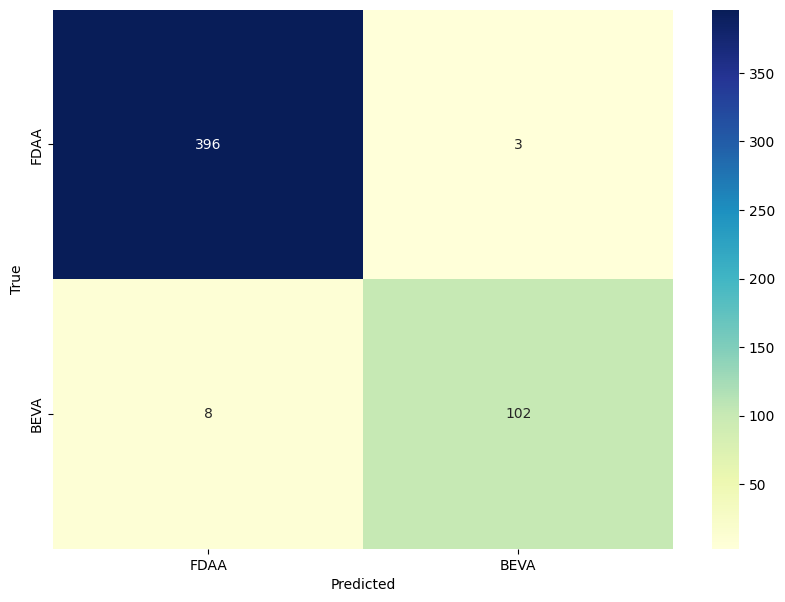

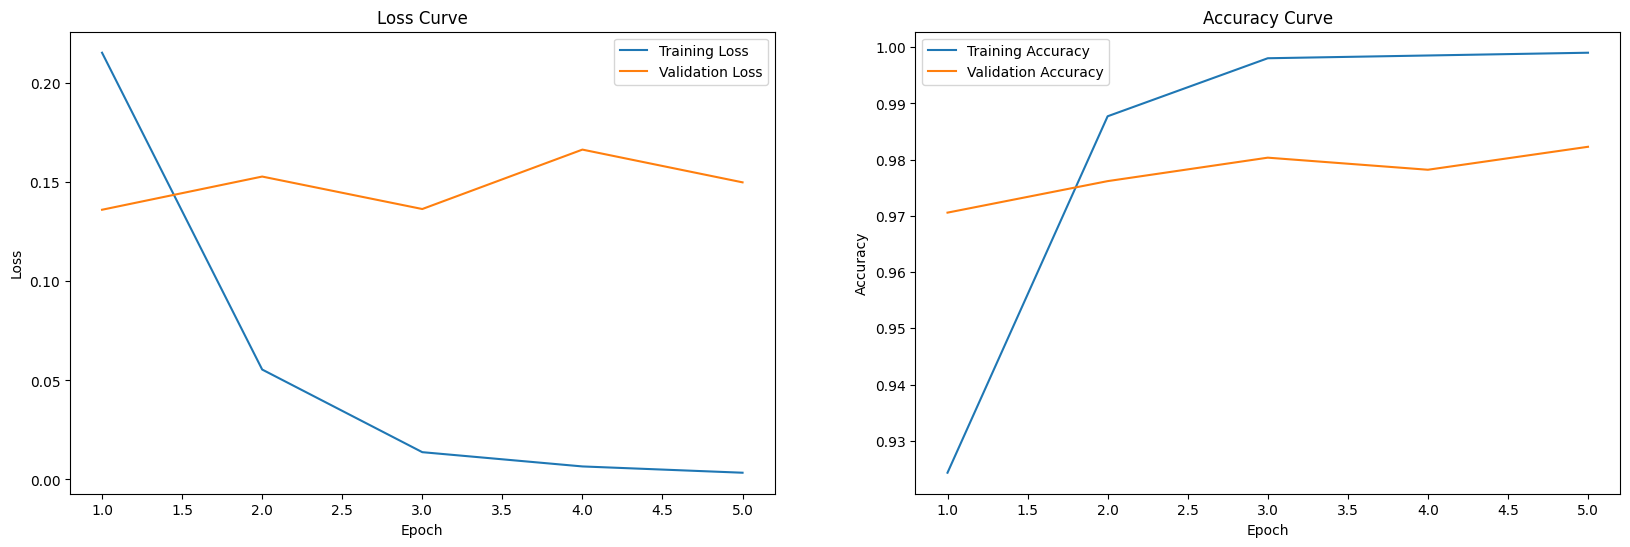

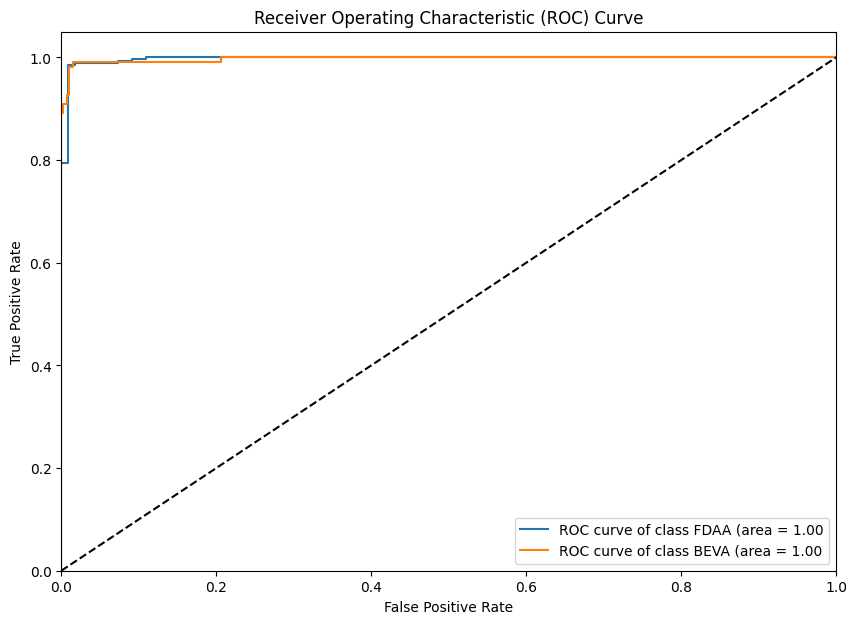

Opening Dataset of Model: FDAA Classifier
Cleaning Dataset of Model: FDAA Classifier
Encoding Labels of Model: FDAA Classifier
{'BAKA': 0, 'MISC': 1, 'ANIP': 2, 'FRTV': 3, 'CUFD': 4}
Splitting Data of Model: FDAA Classifier
Tokenizing: FDAA Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: FDAA Classifier
Using device: cuda
Training of Model: FDAA Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/531 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9309059591813051
Validation loss: 0.25732627858344775
F1 Score (Weighted): 0.9271142895926765


Epoch 2:   0%|          | 0/531 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.15738033227010398
Validation loss: 0.22737866504944132
F1 Score (Weighted): 0.9596096943363307


Epoch 3:   0%|          | 0/531 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.08226291346451418
Validation loss: 0.2019082940370895
F1 Score (Weighted): 0.9671785107749178


Epoch 4:   0%|          | 0/531 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.04060073466660199
Validation loss: 0.2248056348880641
F1 Score (Weighted): 0.9620691332197957


Epoch 5:   0%|          | 0/531 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.034878983035624
Validation loss: 0.2137354243545849
F1 Score (Weighted): 0.9646360973106257
Testing Model: FDAA Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: BAKA
Accuracy: 70/75

Class: MISC
Accuracy: 75/83

Class: ANIP
Accuracy: 87/88

Class: FRTV
Accuracy: 73/73

Class: CUFD
Accuracy: 79/80



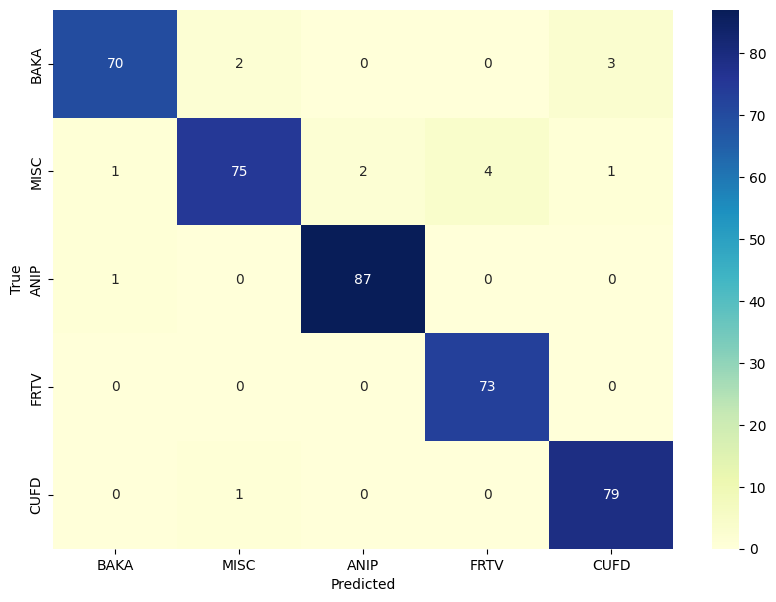

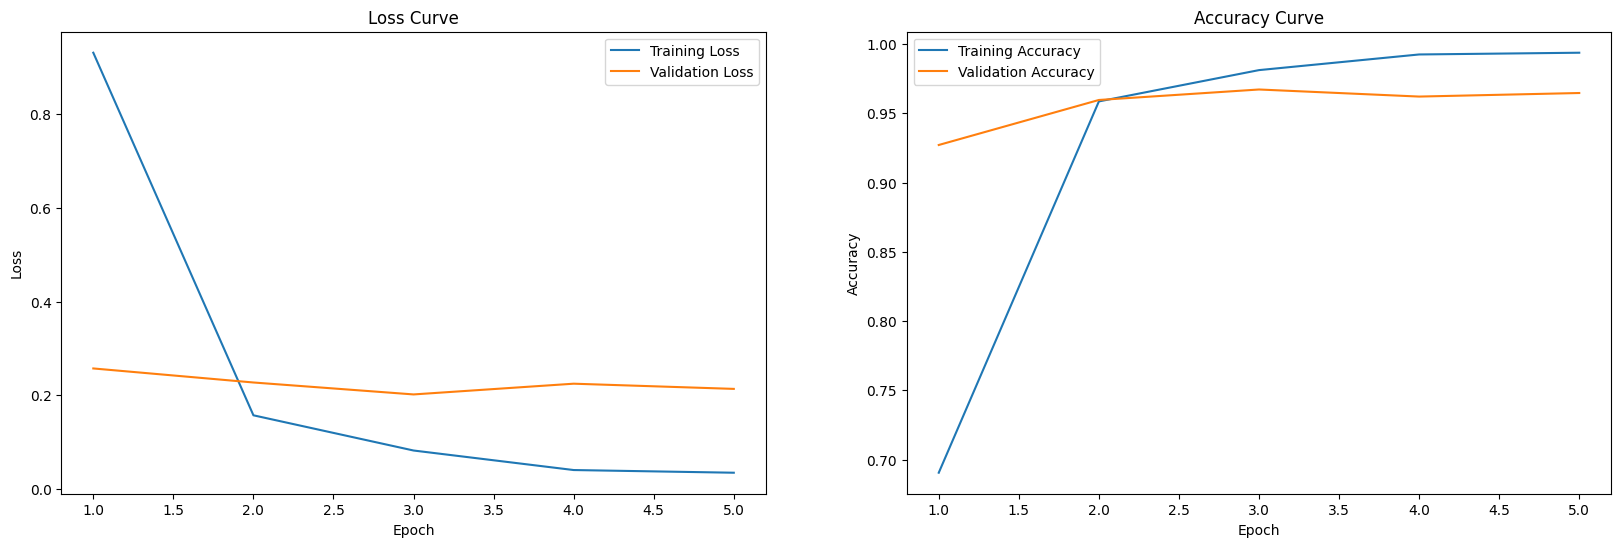

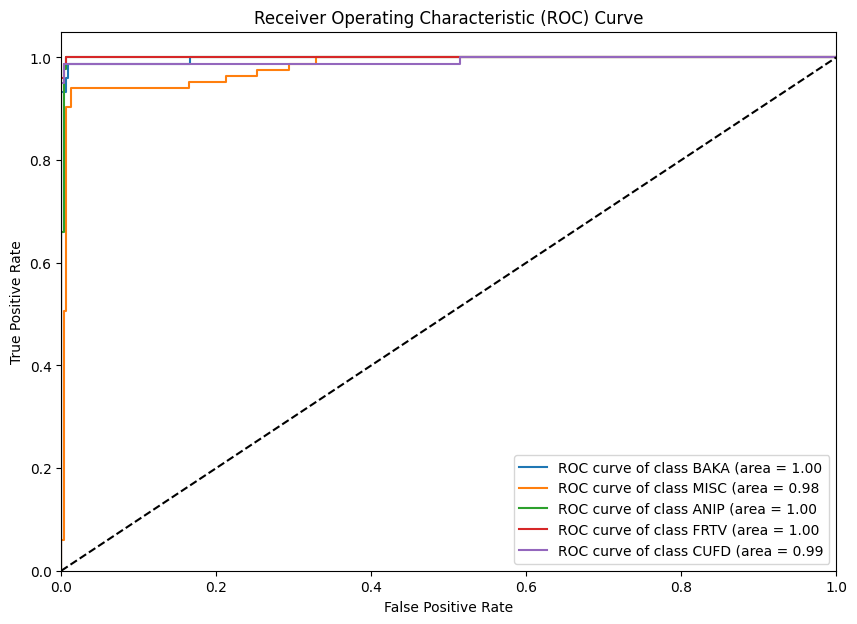

Opening Dataset of Model: BEVA Classifier
Cleaning Dataset of Model: BEVA Classifier
Encoding Labels of Model: BEVA Classifier
{'SODR': 0, 'WATR': 1, 'CTCC': 2}
Splitting Data of Model: BEVA Classifier
Tokenizing: BEVA Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: BEVA Classifier
Using device: cuda
Training of Model: BEVA Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/147 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.8245006118501935
Validation loss: 0.517174454154195
F1 Score (Weighted): 0.7767883090463736


Epoch 2:   0%|          | 0/147 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.34555898069524443
Validation loss: 0.2554366213042994
F1 Score (Weighted): 0.9453135866476489


Epoch 3:   0%|          | 0/147 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.11984723986310213
Validation loss: 0.17119617314656843
F1 Score (Weighted): 0.954129954129954


Epoch 4:   0%|          | 0/147 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.04954464121271863
Validation loss: 0.14358175252690106
F1 Score (Weighted): 0.9729924614880366


Epoch 5:   0%|          | 0/147 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.04160576992269073
Validation loss: 0.15339496919910448
F1 Score (Weighted): 0.945161910679152
Testing Model: BEVA Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: SODR
Accuracy: 55/56

Class: WATR
Accuracy: 22/23

Class: CTCC
Accuracy: 31/32



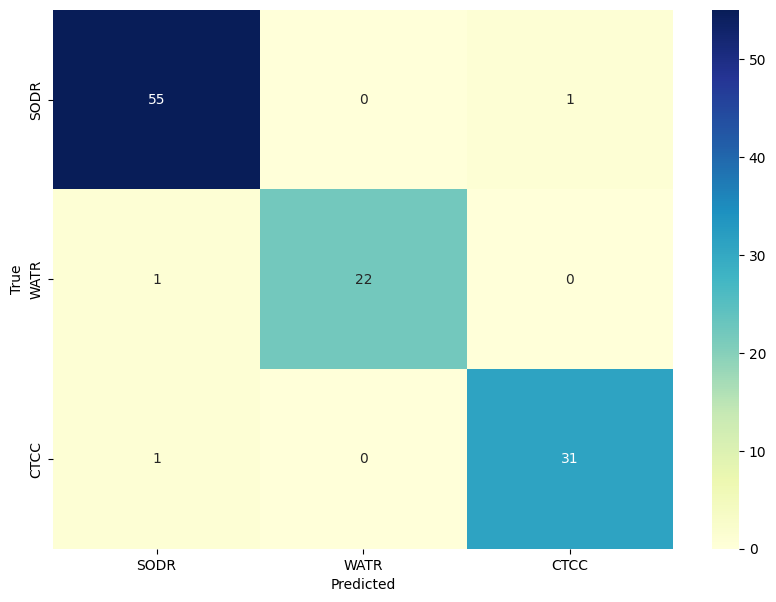

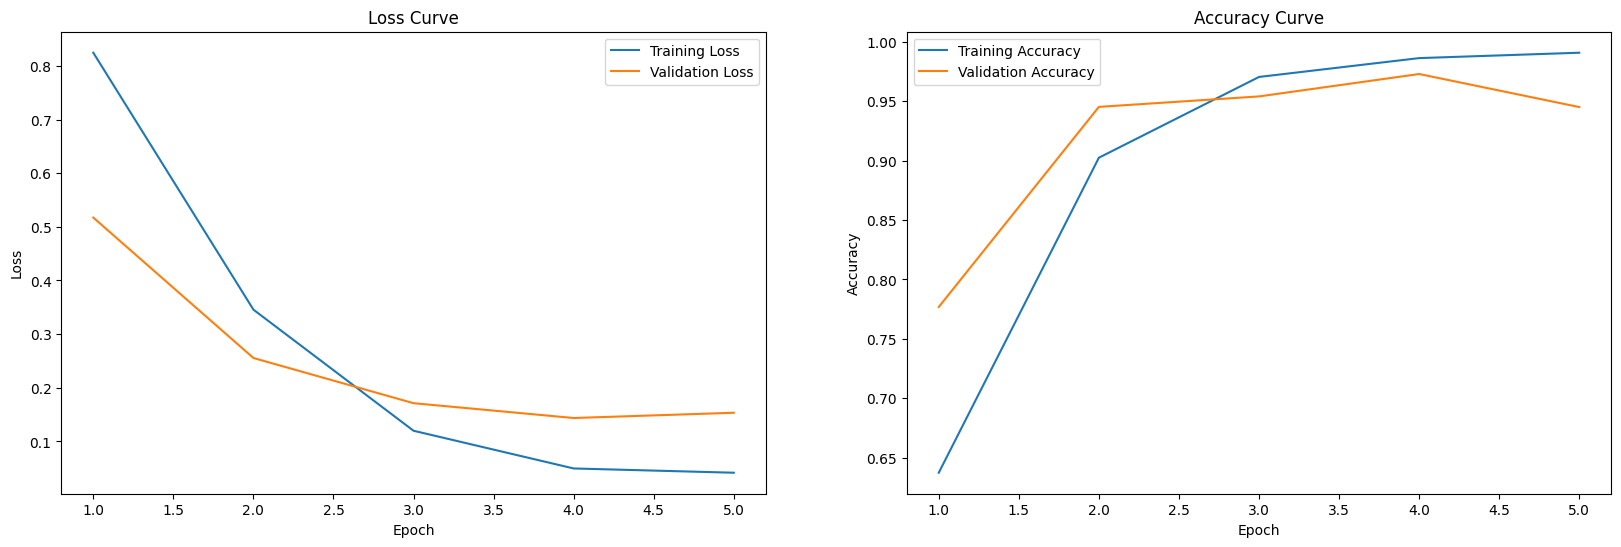

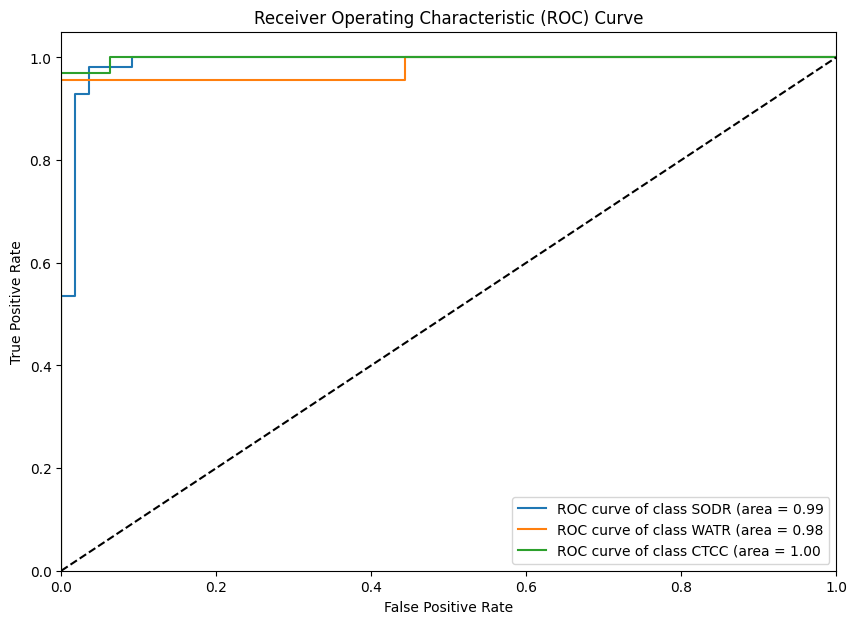

Opening Dataset of Model: SODR Classifier
Cleaning Dataset of Model: SODR Classifier
Encoding Labels of Model: SODR Classifier
{'FIZD': 0, 'ENRD': 1, 'FRUJ': 2}
Splitting Data of Model: SODR Classifier
Tokenizing: SODR Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: SODR Classifier
Using device: cuda
Training of Model: SODR Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/75 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9659495417277019
Validation loss: 0.7649557496372023
F1 Score (Weighted): 0.6189391090167622


Epoch 2:   0%|          | 0/75 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6401851840813955
Validation loss: 0.6087798978153028
F1 Score (Weighted): 0.6360796887112677


Epoch 3:   0%|          | 0/75 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.44614068309466043
Validation loss: 0.5405425539142207
F1 Score (Weighted): 0.7965585224158154


Epoch 4:   0%|          | 0/75 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.3483534756799539
Validation loss: 0.5429156563783947
F1 Score (Weighted): 0.8052883404683959


Epoch 5:   0%|          | 0/75 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.2688954182714224
Validation loss: 0.5315805801043385
F1 Score (Weighted): 0.8053918580234369
Testing Model: SODR Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: FIZD
Accuracy: 24/26

Class: ENRD
Accuracy: 6/14

Class: FRUJ
Accuracy: 17/17



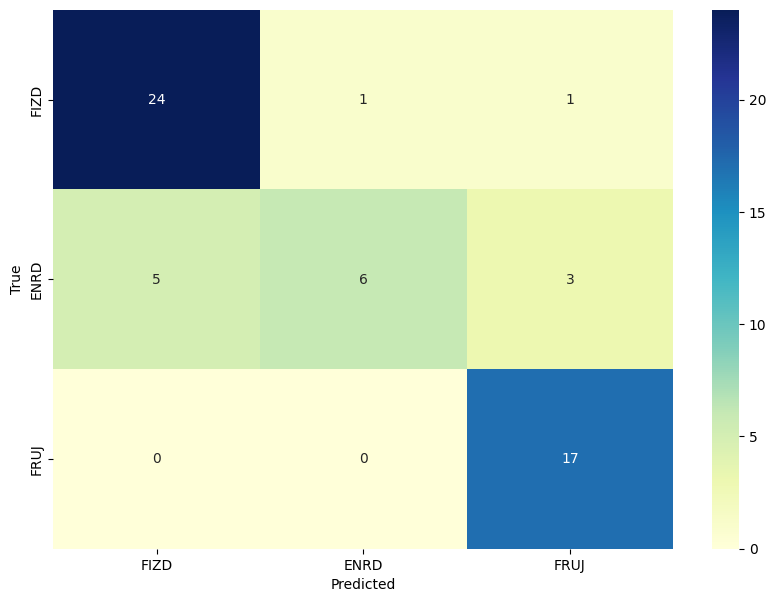

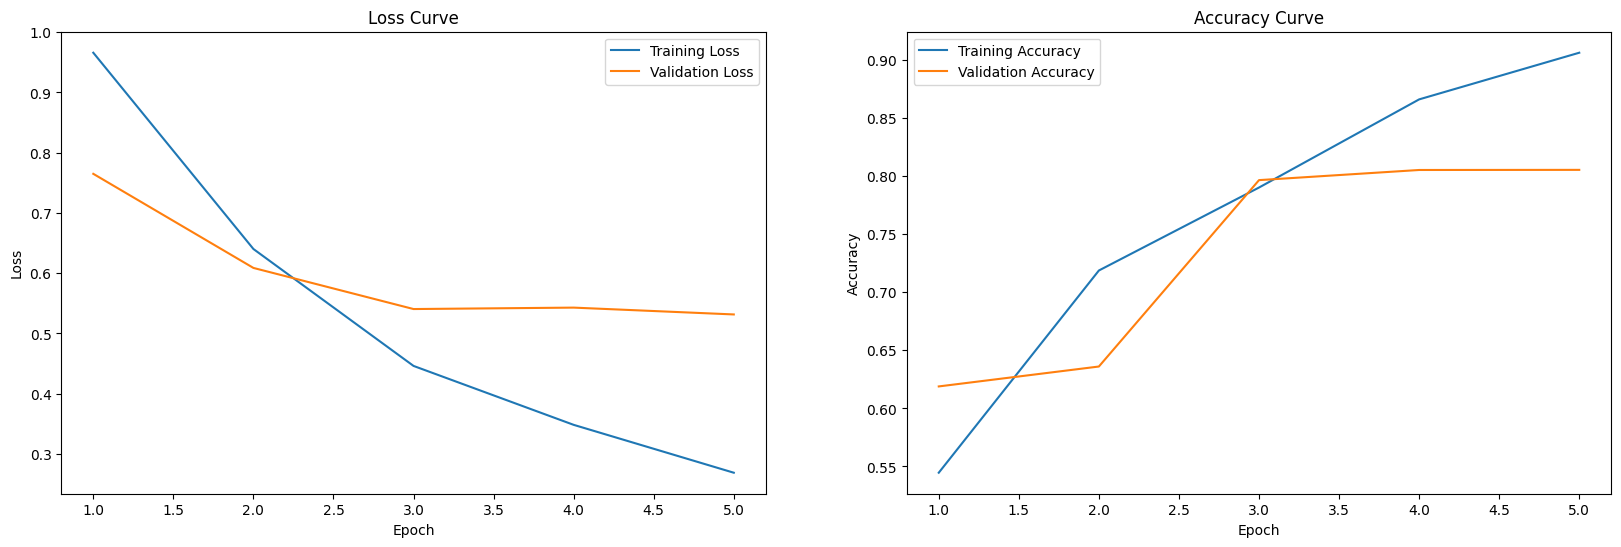

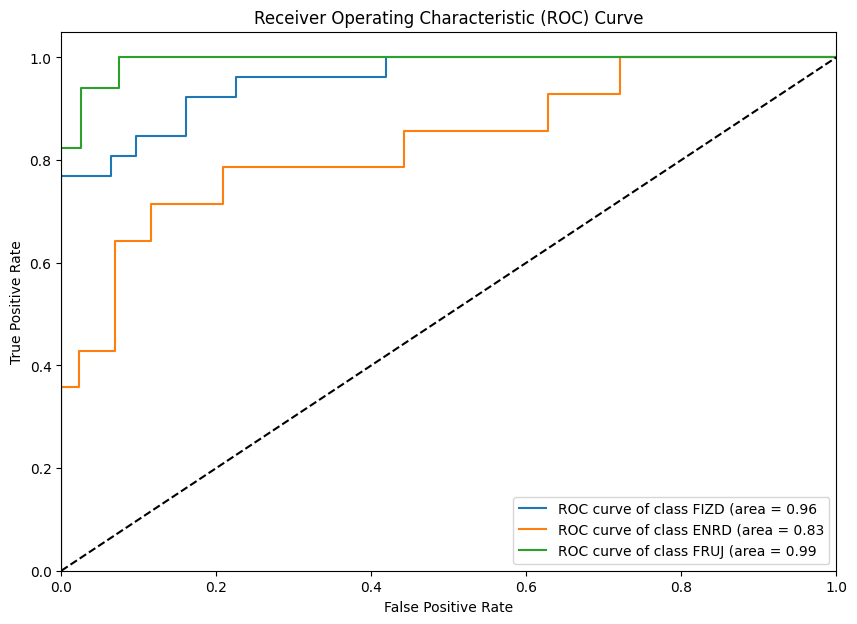

Opening Dataset of Model: WATR Classifier
Cleaning Dataset of Model: WATR Classifier
Encoding Labels of Model: WATR Classifier
{'FLWR': 0, 'SMWR': 1}
Splitting Data of Model: WATR Classifier
Tokenizing: WATR Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: WATR Classifier
Using device: cuda
Training of Model: WATR Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.5925129719318882
Validation loss: 0.3635547310113907
F1 Score (Weighted): 0.9557737260402057


Epoch 2:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3019826602070562
Validation loss: 0.1233216542750597
F1 Score (Weighted): 1.0


Epoch 3:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.14280681131828216
Validation loss: 0.05265657743439078
F1 Score (Weighted): 1.0


Epoch 4:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.09091784438538936
Validation loss: 0.03271725121885538
F1 Score (Weighted): 1.0


Epoch 5:   0%|          | 0/31 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.07463773484191587
Validation loss: 0.026224558940157294
F1 Score (Weighted): 1.0
Testing Model: WATR Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: FLWR
Accuracy: 15/15

Class: SMWR
Accuracy: 8/8



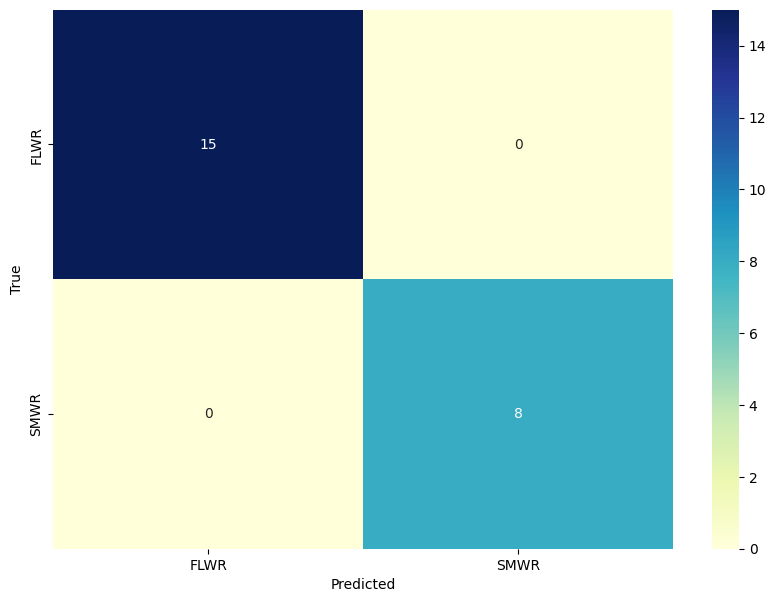

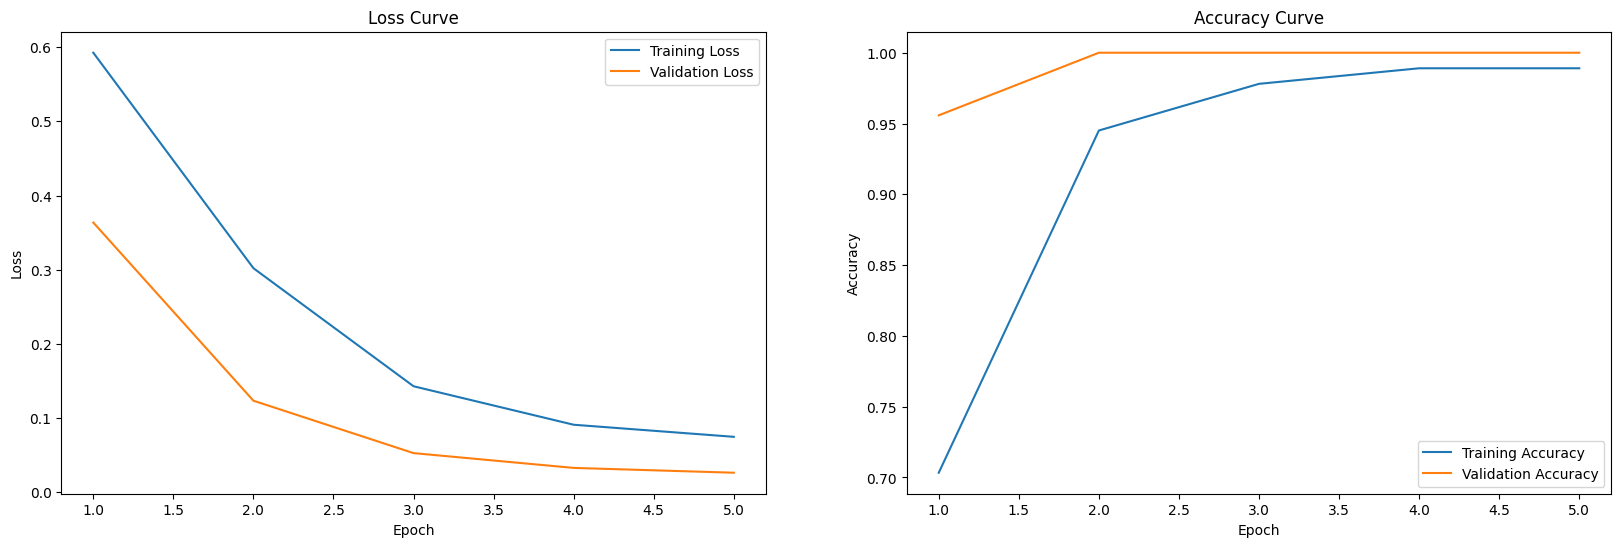

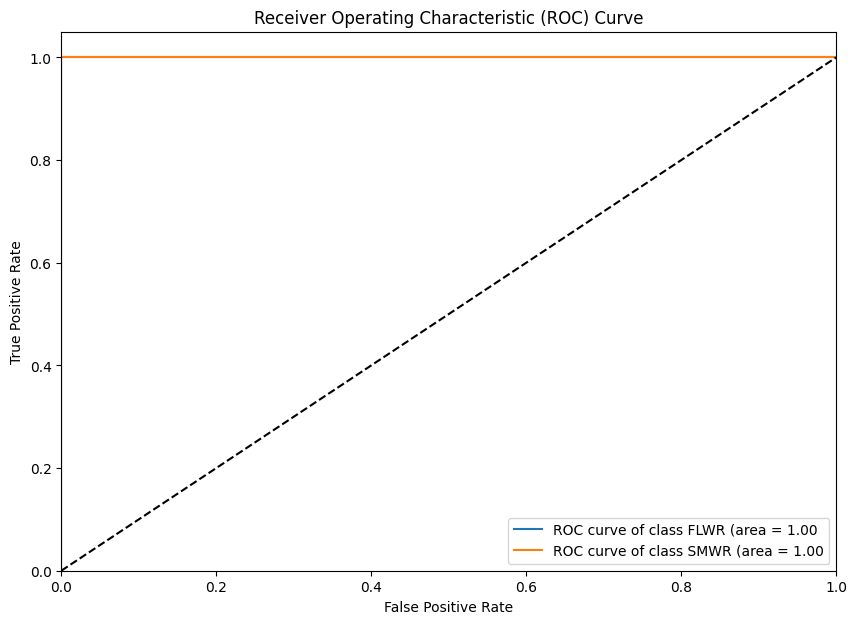

Opening Dataset of Model: CTCC Classifier
Cleaning Dataset of Model: CTCC Classifier
Encoding Labels of Model: CTCC Classifier
{'COFF': 0, 'HTCD': 1, 'SBTB': 2}
Splitting Data of Model: CTCC Classifier
Tokenizing: CTCC Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: CTCC Classifier
Using device: cuda
Training of Model: CTCC Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9242375280175891
Validation loss: 0.5619281449101188
F1 Score (Weighted): 0.9036029411764706


Epoch 2:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.4253649218451409
Validation loss: 0.26092554357918823
F1 Score (Weighted): 0.9686069794050344


Epoch 3:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.2353459069771426
Validation loss: 0.13482096588069742
F1 Score (Weighted): 1.0


Epoch 4:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.16105151921510696
Validation loss: 0.08884297446771101
F1 Score (Weighted): 1.0


Epoch 5:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.12387853825376147
Validation loss: 0.08189095319672064
F1 Score (Weighted): 1.0
Testing Model: CTCC Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: COFF
Accuracy: 11/11

Class: HTCD
Accuracy: 10/10

Class: SBTB
Accuracy: 11/11



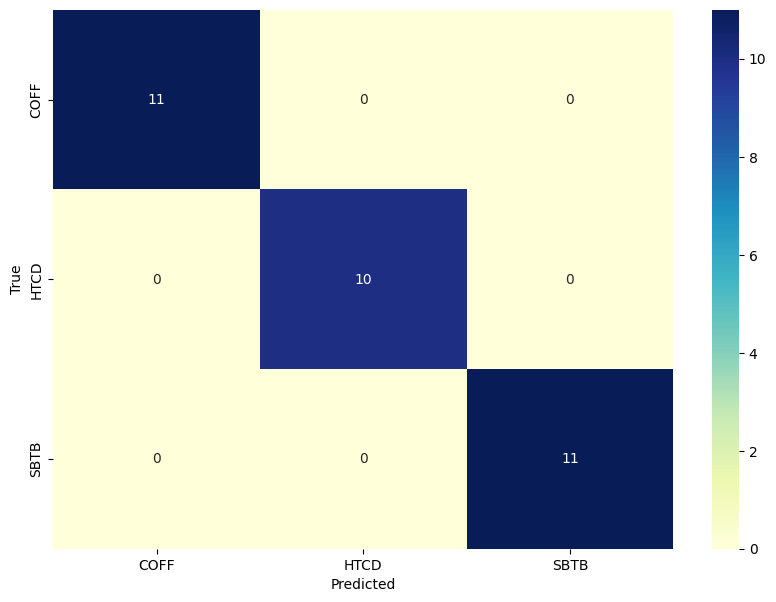

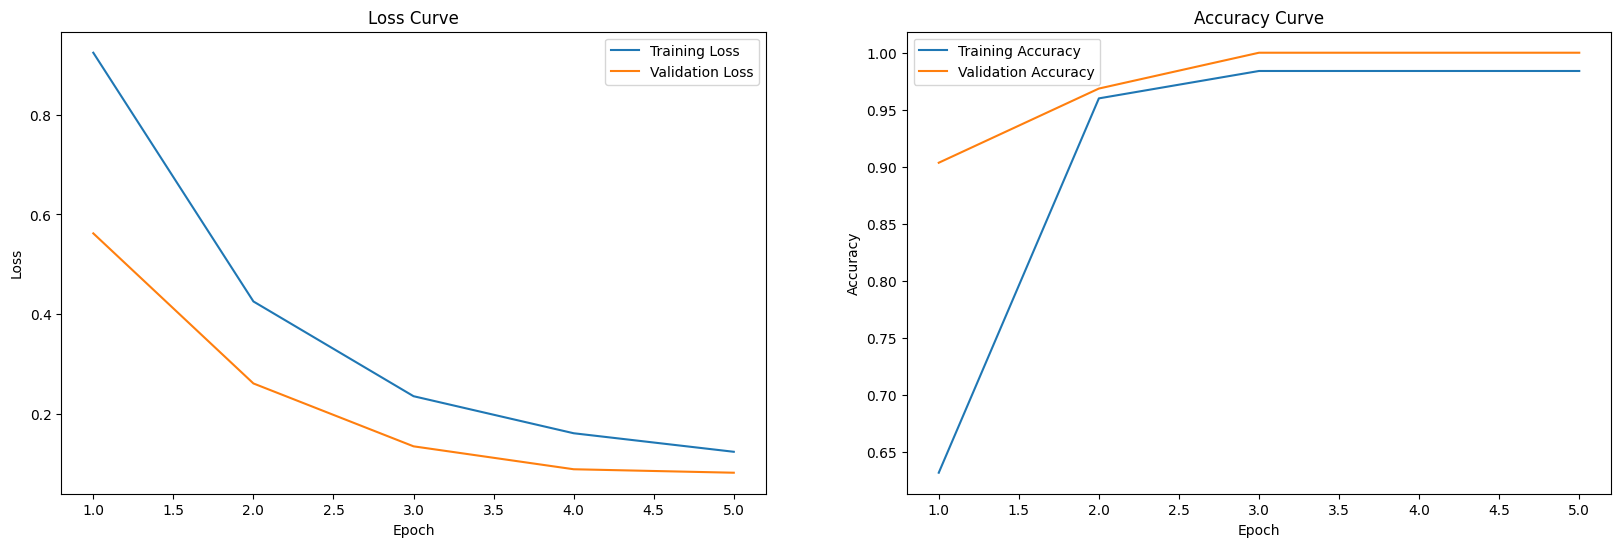

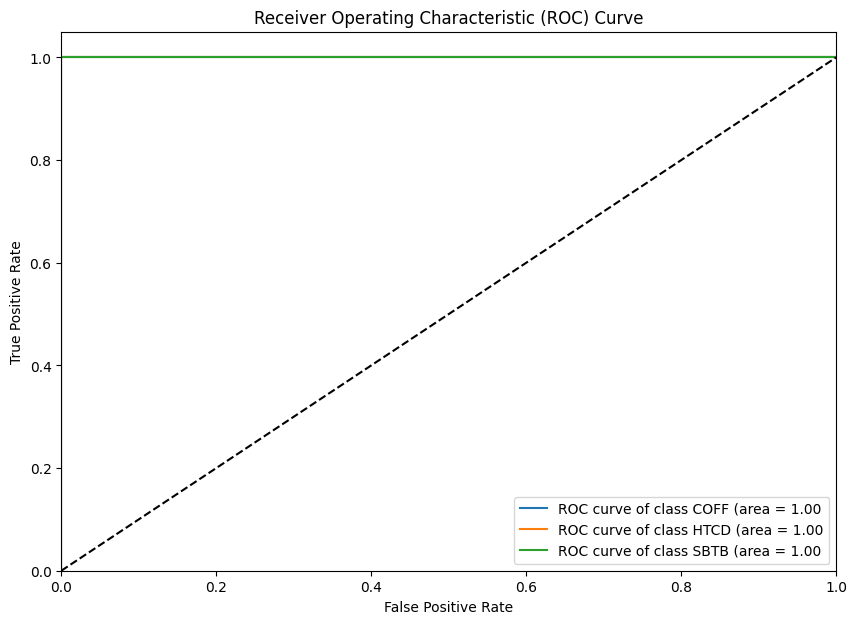

Opening Dataset of Model: BAKA Classifier
Cleaning Dataset of Model: BAKA Classifier
Encoding Labels of Model: BAKA Classifier
{'BAKY': 0, 'BKGD': 1}
Splitting Data of Model: BAKA Classifier
Tokenizing: BAKA Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: BAKA Classifier
Using device: cuda
Training of Model: BAKA Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3868658008920674
Validation loss: 0.1514130815003927
F1 Score (Weighted): 0.9598304271316591


Epoch 2:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.06811150404541652
Validation loss: 0.13511437977341792
F1 Score (Weighted): 0.9733890013495277


Epoch 3:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.014831083966188575
Validation loss: 0.16817456221906468
F1 Score (Weighted): 0.9733890013495277


Epoch 4:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.002060631110268359
Validation loss: 0.16525369610350865
F1 Score (Weighted): 0.9733890013495277


Epoch 5:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0016873235247180898
Validation loss: 0.17181298970423925
F1 Score (Weighted): 0.9733890013495277
Testing Model: BAKA Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: BAKY
Accuracy: 51/51

Class: BKGD
Accuracy: 23/25



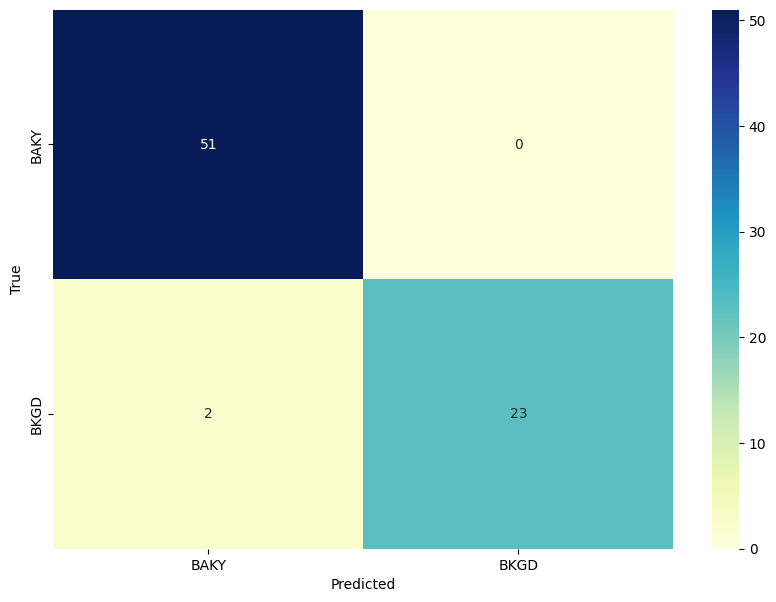

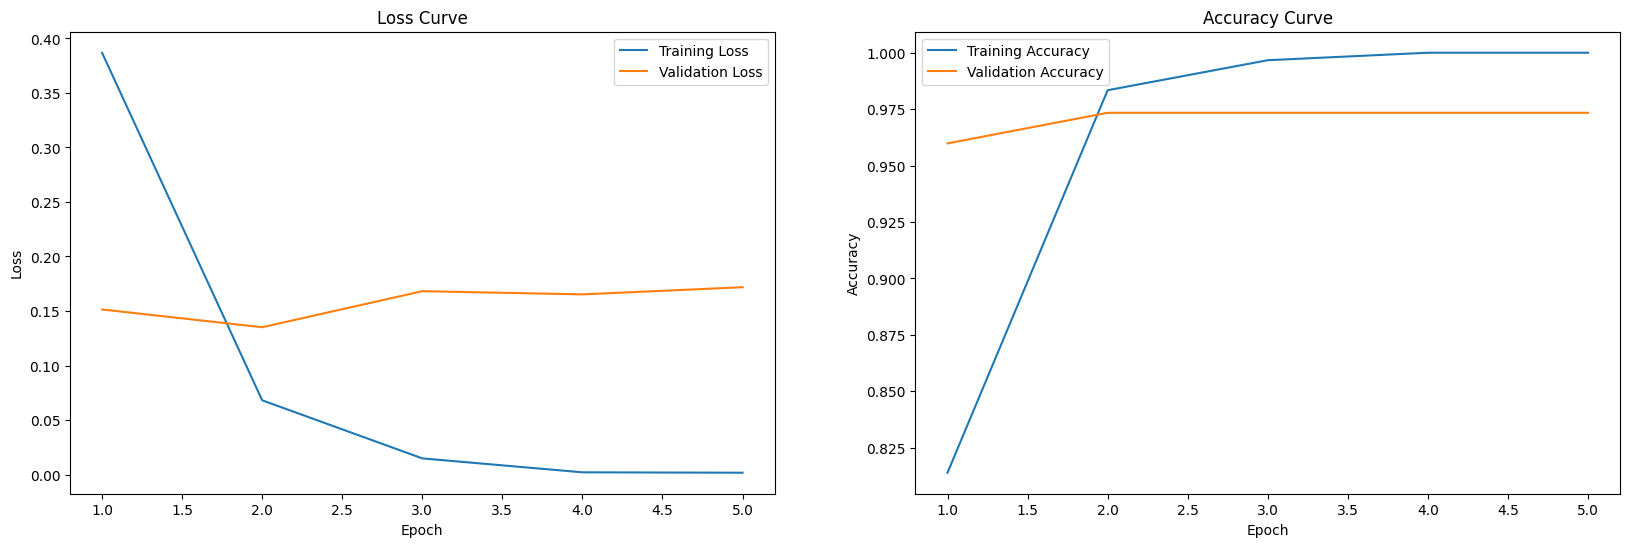

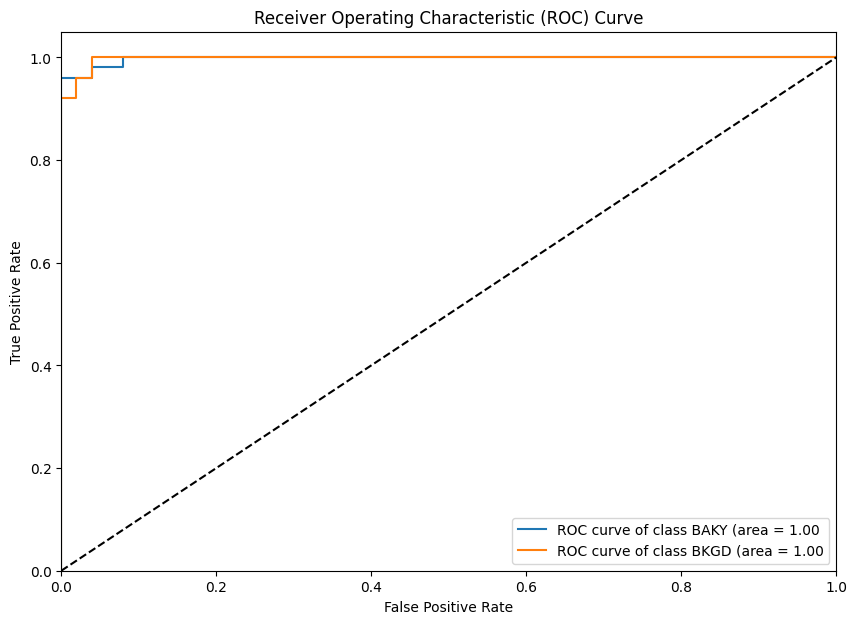

Opening Dataset of Model: MISC Classifier
Cleaning Dataset of Model: MISC Classifier
Encoding Labels of Model: MISC Classifier
{'CHSW': 0, 'JAMH': 1, 'SAUC': 2}
Splitting Data of Model: MISC Classifier
Tokenizing: MISC Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: MISC Classifier
Using device: cuda
Training of Model: MISC Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9644363396339588
Validation loss: 0.6423416989190238
F1 Score (Weighted): 0.6836775247247493


Epoch 2:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5096436598682189
Validation loss: 0.35819510609975885
F1 Score (Weighted): 0.891216910398496


Epoch 3:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.20302841572409813
Validation loss: 0.2423653399039592
F1 Score (Weighted): 0.927948957360722


Epoch 4:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.09103692437077428
Validation loss: 0.2079438197626067
F1 Score (Weighted): 0.9404103983935916


Epoch 5:   0%|          | 0/111 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.07068975027314983
Validation loss: 0.20577745206121886
F1 Score (Weighted): 0.9404103983935916
Testing Model: MISC Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: CHSW
Accuracy: 32/33

Class: JAMH
Accuracy: 30/32

Class: SAUC
Accuracy: 17/19



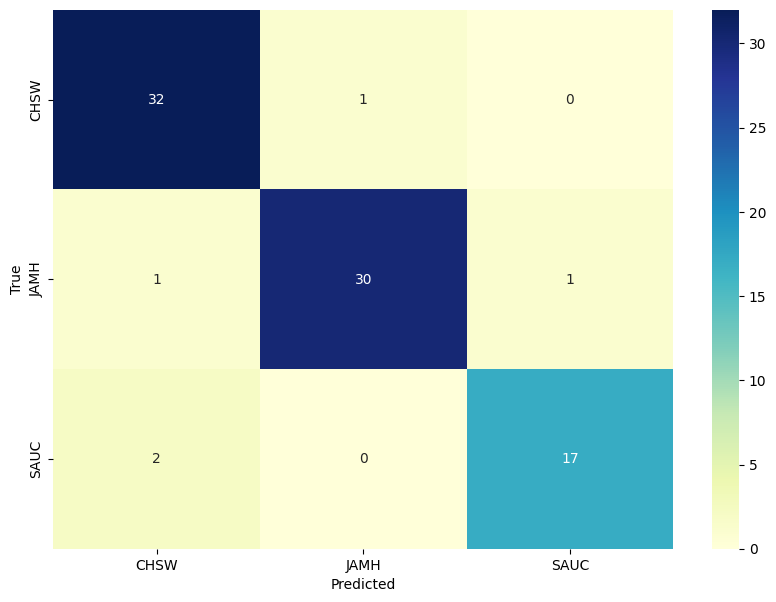

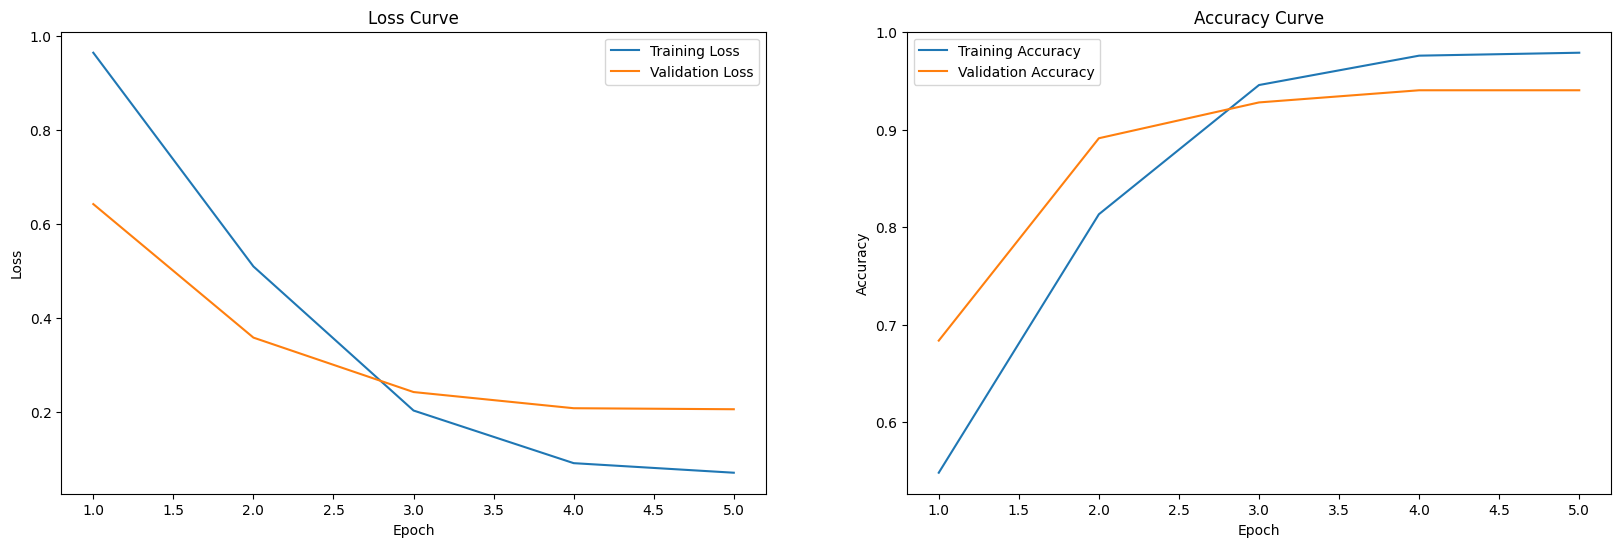

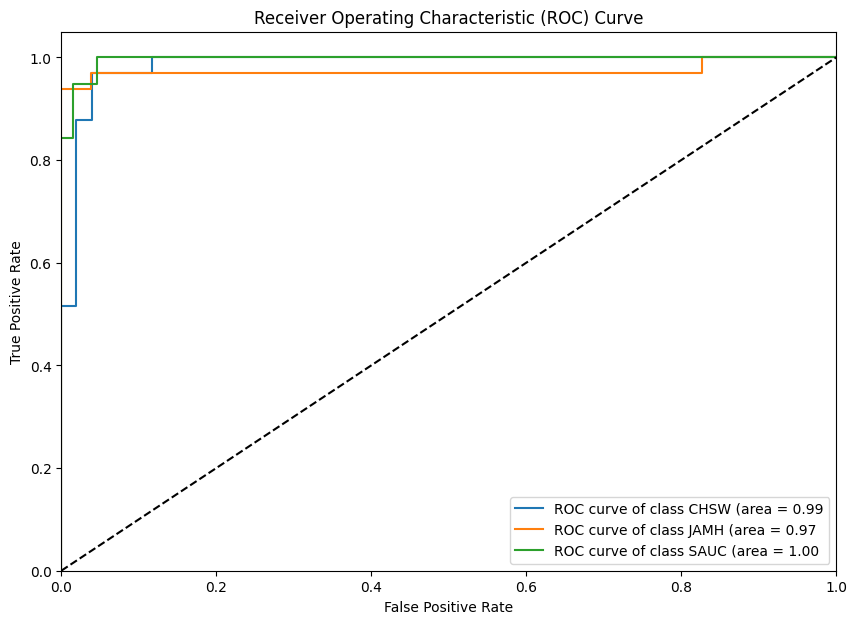

Opening Dataset of Model: ANIP Classifier
Cleaning Dataset of Model: ANIP Classifier
Encoding Labels of Model: ANIP Classifier
{'DAIR': 0, 'FISH': 1, 'MEAT': 2}
Splitting Data of Model: ANIP Classifier
Tokenizing: ANIP Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: ANIP Classifier
Using device: cuda
Training of Model: ANIP Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.7858610172302295
Validation loss: 0.36418318301439284
F1 Score (Weighted): 0.9258522727272727


Epoch 2:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.21133999961117902
Validation loss: 0.07733824125801524
F1 Score (Weighted): 0.9773060946891842


Epoch 3:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.06302693285621129
Validation loss: 0.05609298006941875
F1 Score (Weighted): 0.9885161964472308


Epoch 4:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.051490369320520736
Validation loss: 0.08379642206709832
F1 Score (Weighted): 0.9773060946891842


Epoch 5:   0%|          | 0/117 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0530809072805489
Validation loss: 0.10914180901988099
F1 Score (Weighted): 0.9773060946891842
Testing Model: ANIP Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: DAIR
Accuracy: 36/36

Class: FISH
Accuracy: 14/15

Class: MEAT
Accuracy: 36/37



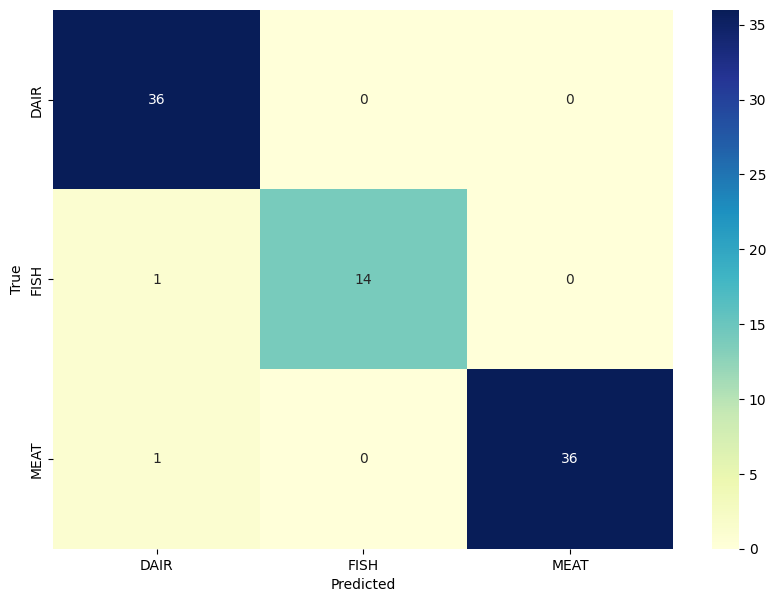

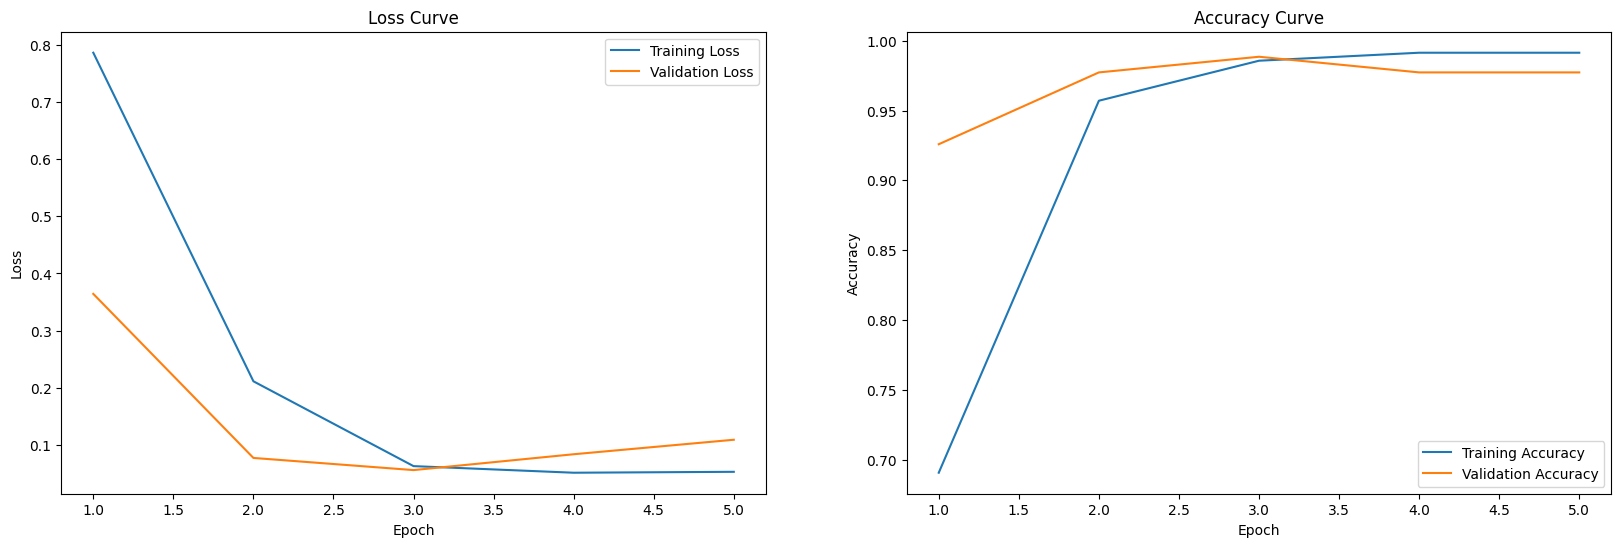

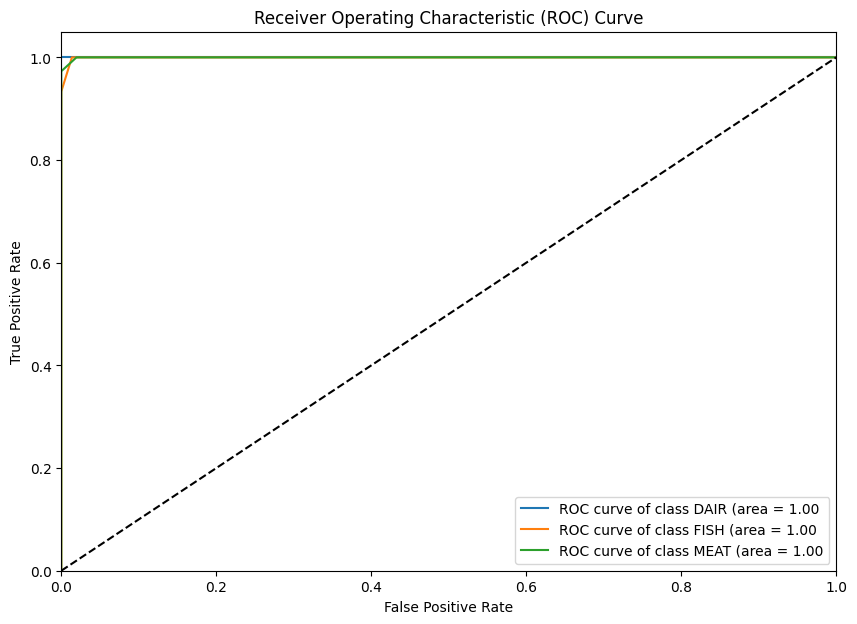

Opening Dataset of Model: FRTV Classifier
Cleaning Dataset of Model: FRTV Classifier
Encoding Labels of Model: FRTV Classifier
{'FRFR': 0, 'FRVG': 1, 'POTA': 2}
Splitting Data of Model: FRTV Classifier
Tokenizing: FRTV Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: FRTV Classifier
Using device: cuda
Training of Model: FRTV Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.8868761753913054
Validation loss: 0.5968940812349319
F1 Score (Weighted): 0.7329605814928711


Epoch 2:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.3705435302684602
Validation loss: 0.1683105655014515
F1 Score (Weighted): 0.9575266539142618


Epoch 3:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.09037658141100223
Validation loss: 0.09034745015203953
F1 Score (Weighted): 0.9862381616234684


Epoch 4:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.03717611159783663
Validation loss: 0.081641112472862
F1 Score (Weighted): 0.9862381616234684


Epoch 5:   0%|          | 0/97 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.010633363076437688
Validation loss: 0.08120827822946013
F1 Score (Weighted): 0.9862381616234684
Testing Model: FRTV Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: FRFR
Accuracy: 23/24

Class: FRVG
Accuracy: 41/41

Class: POTA
Accuracy: 8/8



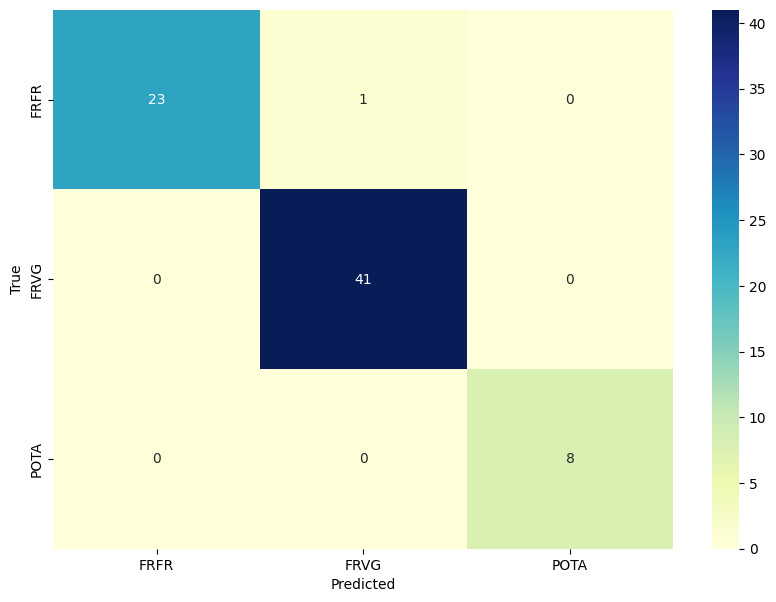

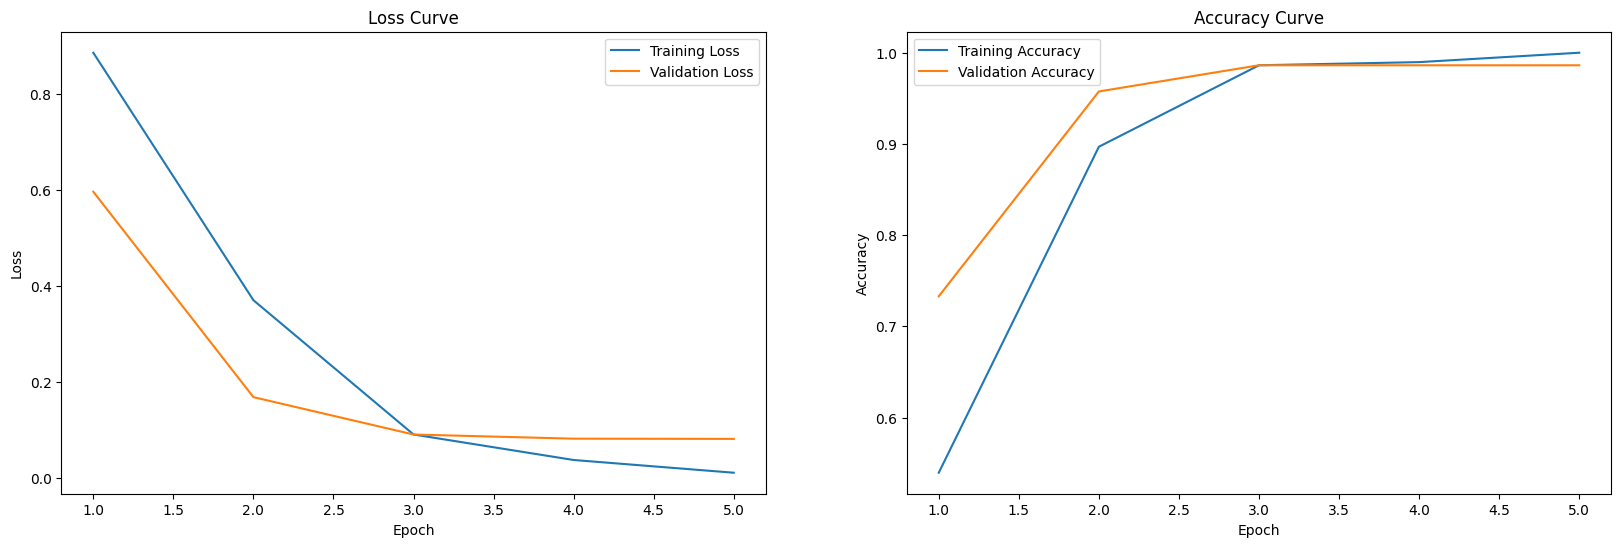

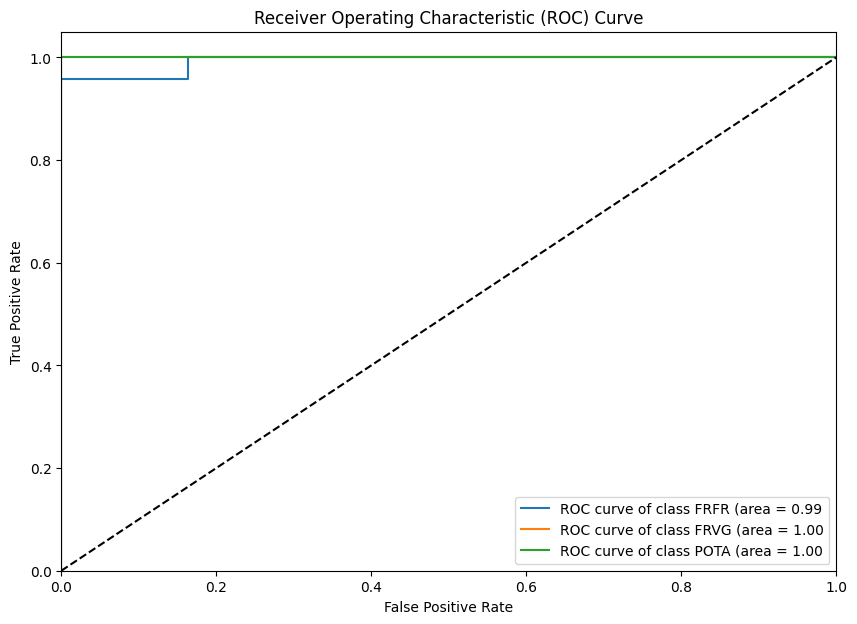

Opening Dataset of Model: CUFD Classifier
Cleaning Dataset of Model: CUFD Classifier
Encoding Labels of Model: CUFD Classifier
{'BRKF': 0, 'BSOI': 1, 'CANF': 2, 'RICE': 3}
Splitting Data of Model: CUFD Classifier
Tokenizing: CUFD Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: CUFD Classifier
Using device: cuda
Training of Model: CUFD Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.071583940735403
Validation loss: 0.5372043947378794
F1 Score (Weighted): 0.9623497007256742


Epoch 2:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.35277425926530137
Validation loss: 0.16759952544062226
F1 Score (Weighted): 0.9875701684041701


Epoch 3:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.1054133198768744
Validation loss: 0.10301246914874625
F1 Score (Weighted): 0.9875701684041701


Epoch 4:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.05285354300384533
Validation loss: 0.08860942090137137
F1 Score (Weighted): 0.9875701684041701


Epoch 5:   0%|          | 0/106 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.0442244441178188
Validation loss: 0.08712986349645588
F1 Score (Weighted): 0.9875701684041701
Testing Model: CUFD Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: BRKF
Accuracy: 16/16

Class: BSOI
Accuracy: 28/28

Class: CANF
Accuracy: 21/22

Class: RICE
Accuracy: 14/14



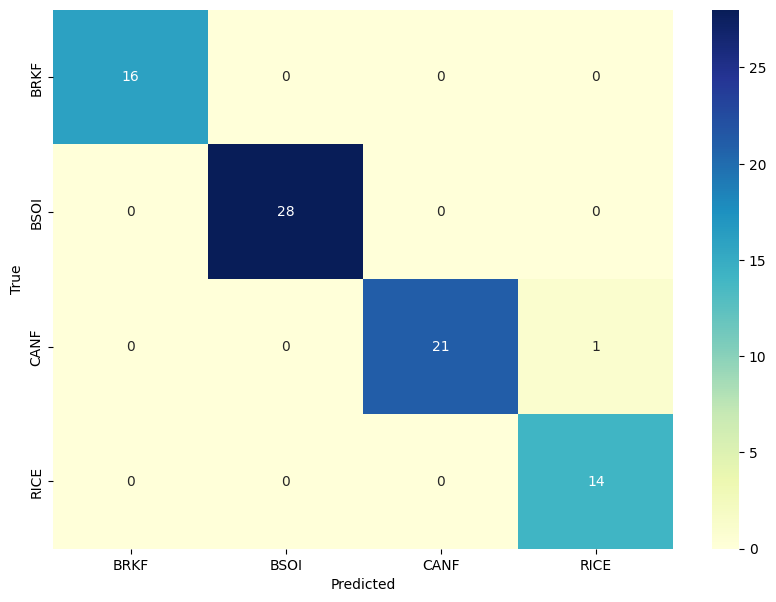

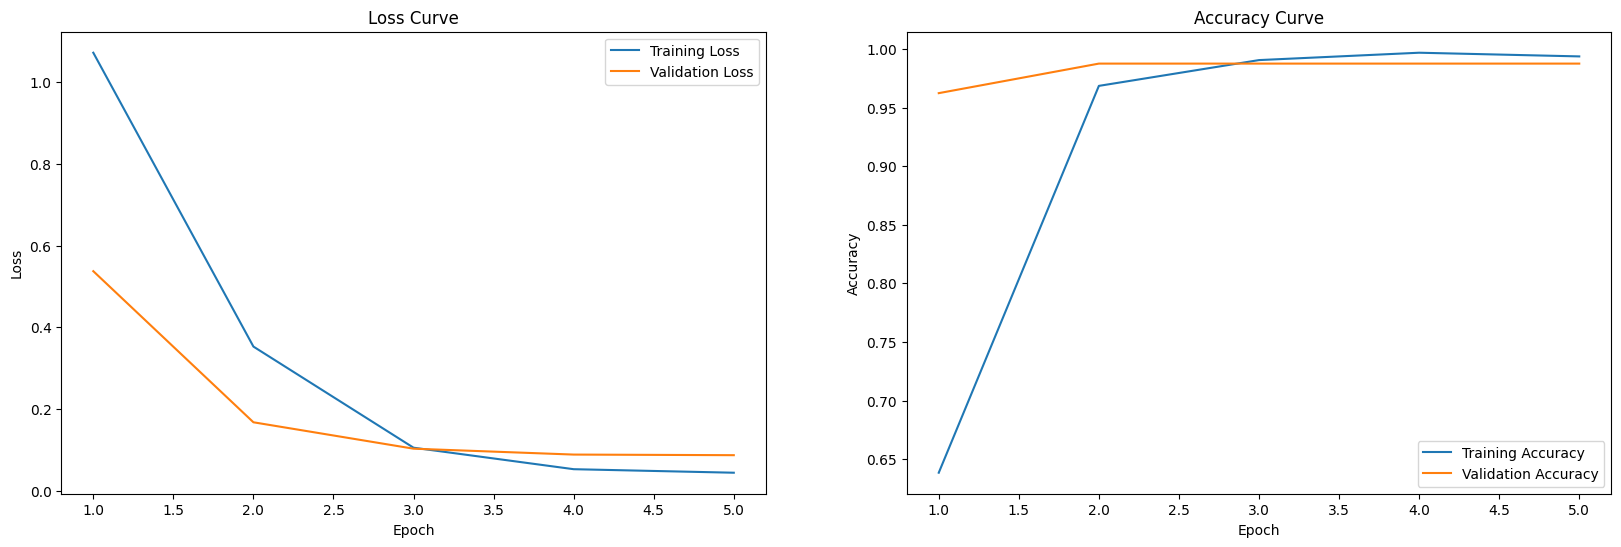

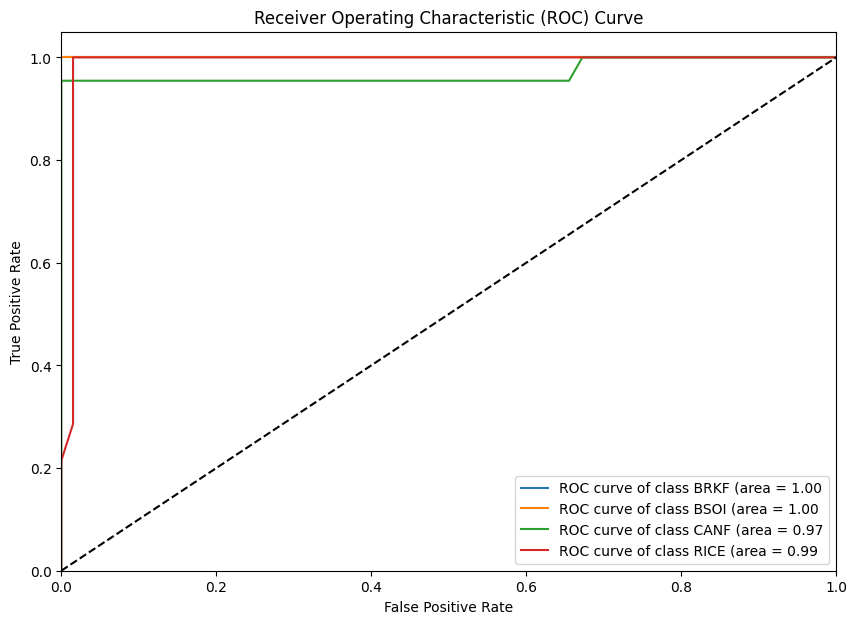

Opening Dataset of Model: BAKY Classifier
Cleaning Dataset of Model: BAKY Classifier
Encoding Labels of Model: BAKY Classifier
{'BRRL': 0, 'INCK': 1, 'PKWT': 2, 'WHBR': 3, 'WHMB': 4}
Splitting Data of Model: BAKY Classifier
Tokenizing: BAKY Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: BAKY Classifier
Using device: cuda
Training of Model: BAKY Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.48890980201609
Validation loss: 1.2649394273757935
F1 Score (Weighted): 0.5188610333392704


Epoch 2:   0%|          | 0/68 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.1525645536534928
Validation loss: 0.9605028909795424
F1 Score (Weighted): 0.7129309240035883


Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.901997067472514
Validation loss: 0.730460021425696
F1 Score (Weighted): 0.9208982738394503


Epoch 4:   0%|          | 0/68 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.7213687099078122
Validation loss: 0.5868520052993998
F1 Score (Weighted): 0.9407682101180554


Epoch 5:   0%|          | 0/68 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.6003283025587306
Validation loss: 0.5426027958883959
F1 Score (Weighted): 0.9606604747162023
Testing Model: BAKY Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: BRRL
Accuracy: 9/11

Class: INCK
Accuracy: 9/10

Class: PKWT
Accuracy: 10/10

Class: WHBR
Accuracy: 12/12

Class: WHMB
Accuracy: 8/8



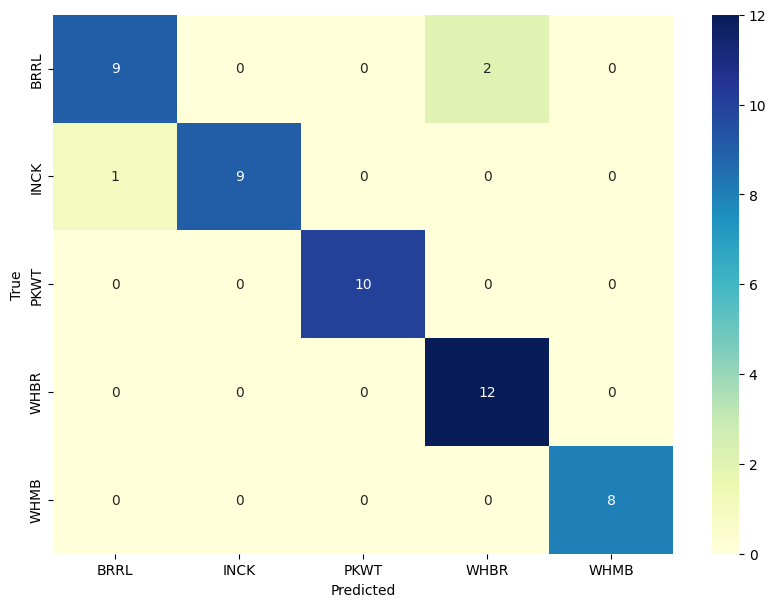

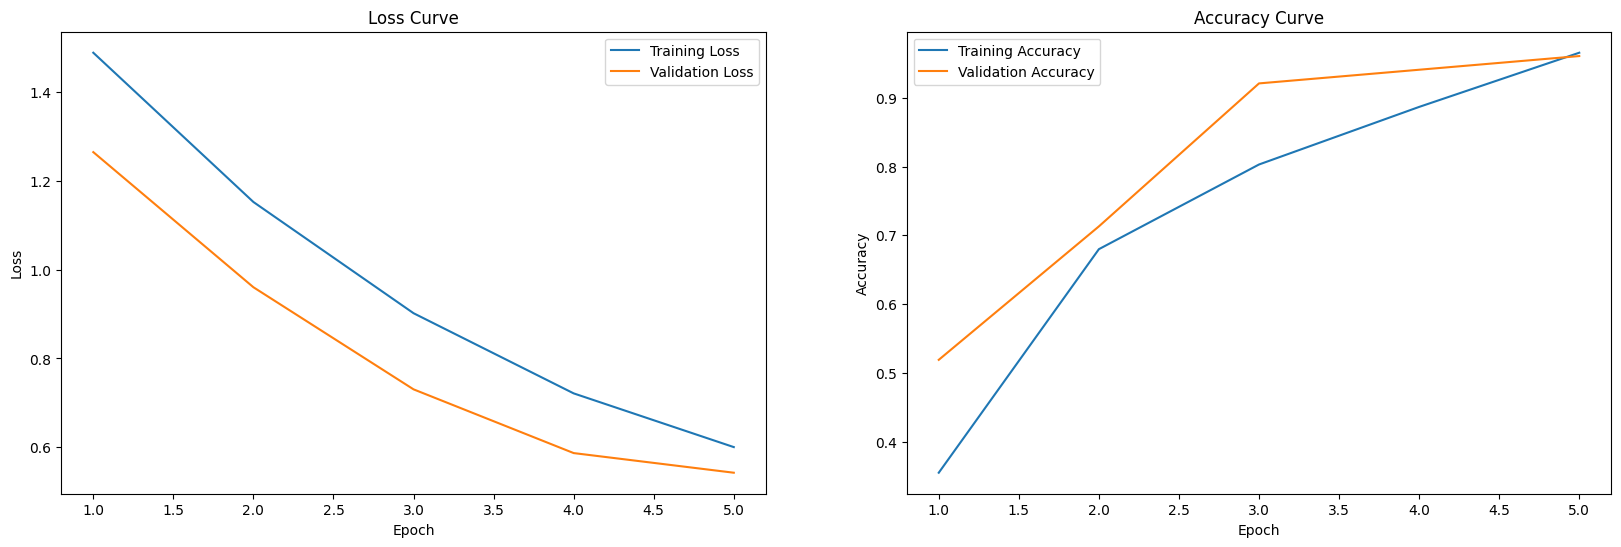

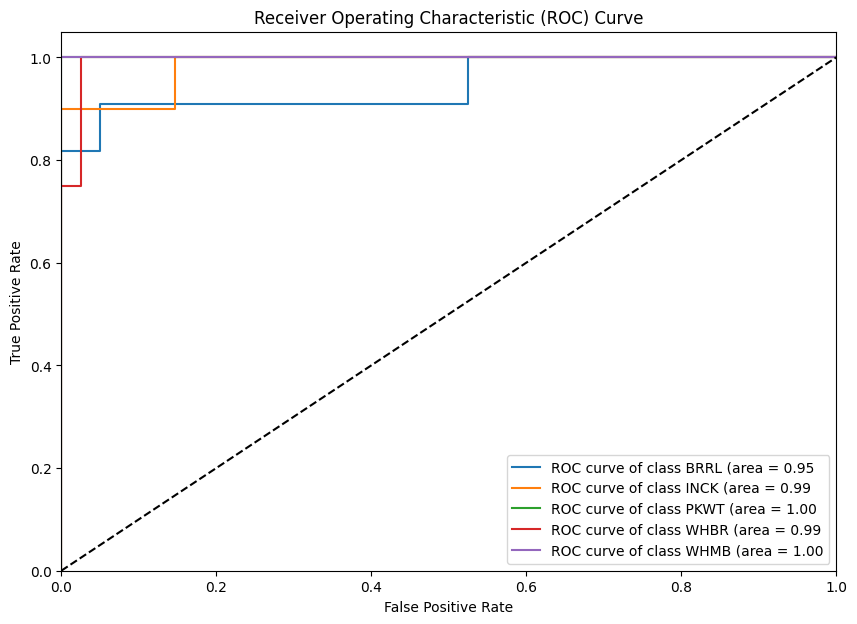

Opening Dataset of Model: BKGD Classifier
Cleaning Dataset of Model: BKGD Classifier
Encoding Labels of Model: BKGD Classifier
{'SRFL': 0, 'OTFL': 1, 'PWSU': 2}
Splitting Data of Model: BKGD Classifier
Tokenizing: BKGD Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: BKGD Classifier
Using device: cuda
Training of Model: BKGD Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9496725671219103
Validation loss: 0.8160033524036407
F1 Score (Weighted): 0.47392857142857137


Epoch 2:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7324205438296
Validation loss: 0.6095893548594581
F1 Score (Weighted): 0.730057142857143


Epoch 3:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5420678962360729
Validation loss: 0.431598703066508
F1 Score (Weighted): 0.7686956521739131


Epoch 4:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.4038245551513903
Validation loss: 0.2987159424357944
F1 Score (Weighted): 0.9103030303030303


Epoch 5:   0%|          | 0/33 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.3103933257587028
Validation loss: 0.2649456295702193
F1 Score (Weighted): 0.9580952380952381
Testing Model: BKGD Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: SRFL
Accuracy: 2/4

Class: OTFL
Accuracy: 10/10

Class: PWSU
Accuracy: 11/11



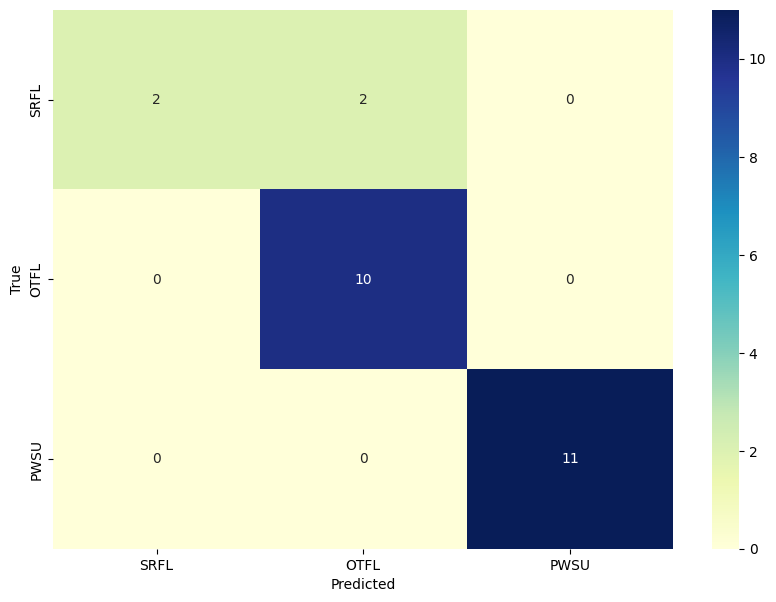

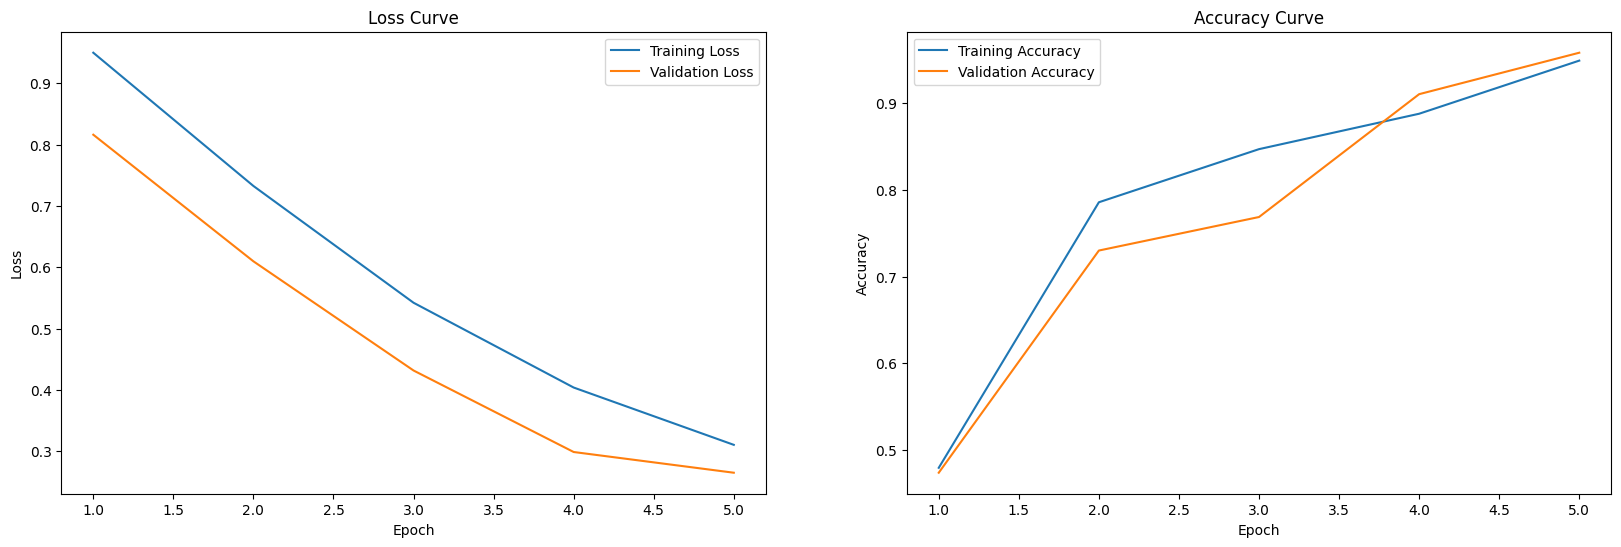

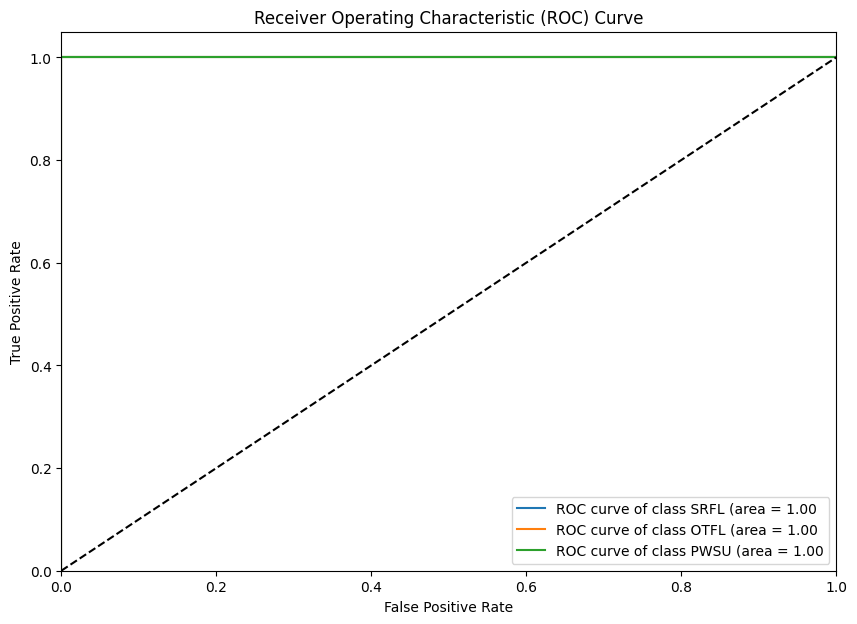

Opening Dataset of Model: CHSW Classifier
Cleaning Dataset of Model: CHSW Classifier
Encoding Labels of Model: CHSW Classifier
{'CHOC': 0, 'GUMM': 1, 'OTSW': 2}
Splitting Data of Model: CHSW Classifier
Tokenizing: CHSW Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: CHSW Classifier
Using device: cuda
Training of Model: CHSW Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.0745222235834875
Validation loss: 0.9626301797953519
F1 Score (Weighted): 0.3133309378368667


Epoch 2:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.8469019698542218
Validation loss: 0.6485245471650903
F1 Score (Weighted): 0.9054683456960496


Epoch 3:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5322231019652167
Validation loss: 0.46178692985664715
F1 Score (Weighted): 0.8760942760942761


Epoch 4:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.3584775529628576
Validation loss: 0.41614653170108795
F1 Score (Weighted): 0.8760942760942761


Epoch 5:   0%|          | 0/43 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.2811392715504003
Validation loss: 0.41421671347184613
F1 Score (Weighted): 0.9054683456960496
Testing Model: CHSW Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: CHOC
Accuracy: 9/9

Class: GUMM
Accuracy: 13/14

Class: OTSW
Accuracy: 7/10



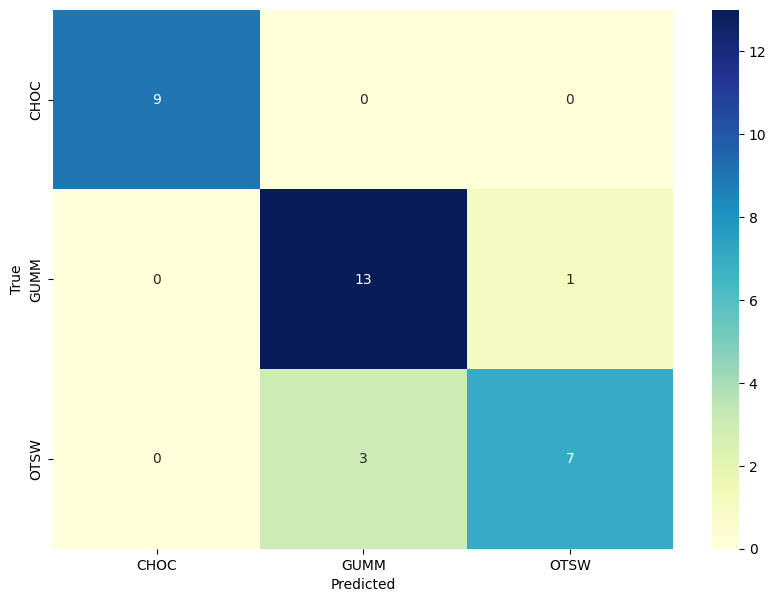

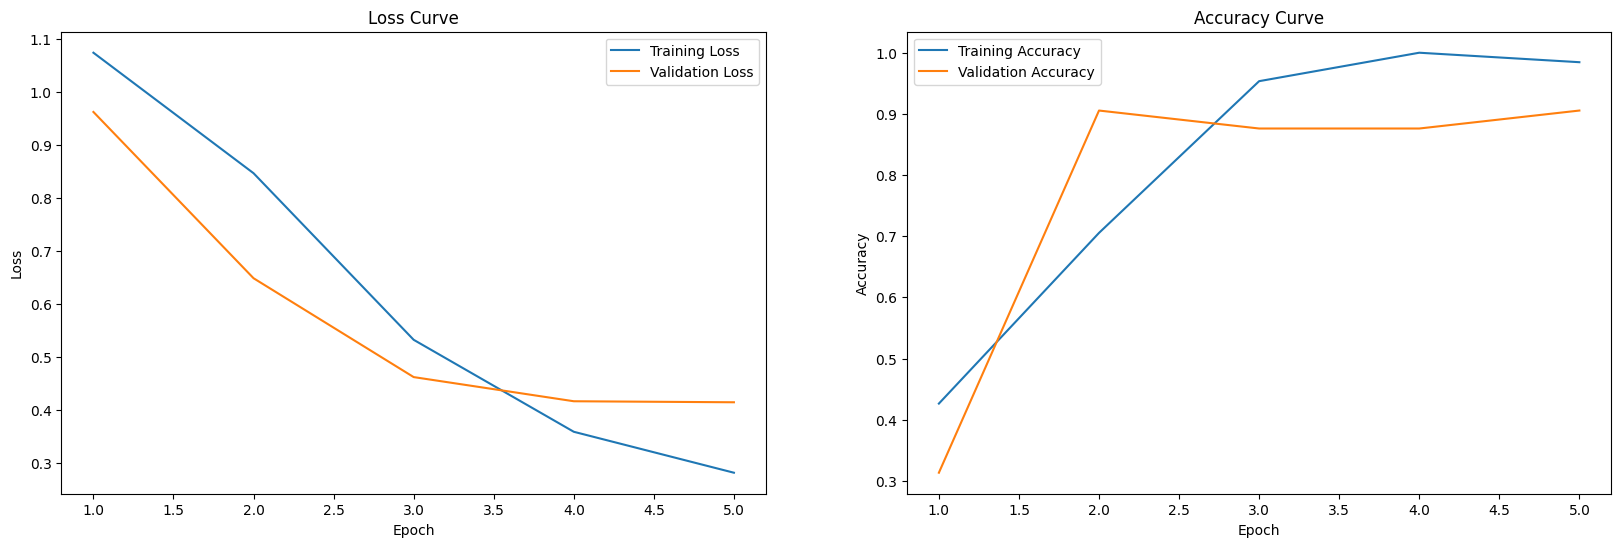

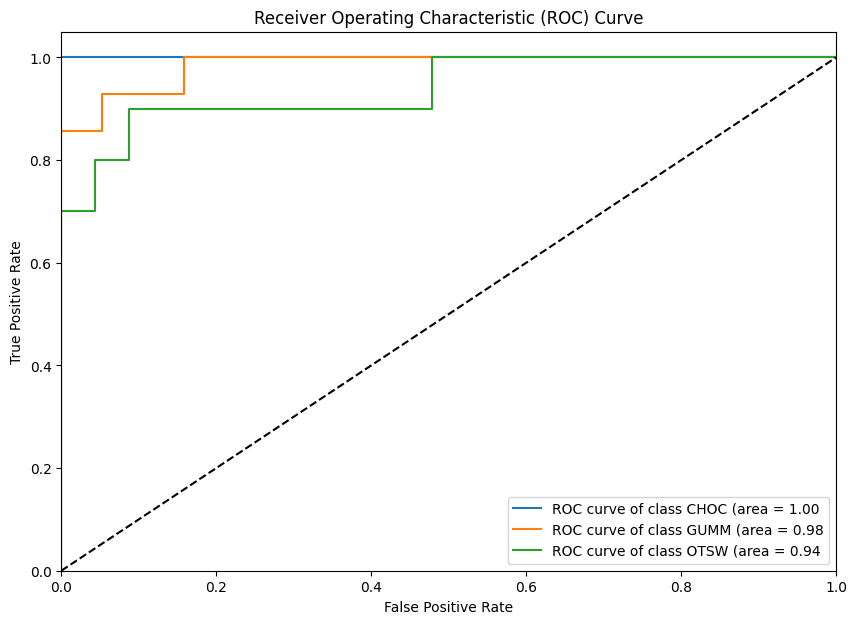

Opening Dataset of Model: JAMH Classifier
Cleaning Dataset of Model: JAMH Classifier
Encoding Labels of Model: JAMH Classifier
{'HONY': 0, 'JAMM': 1, 'CRSP': 2}
Splitting Data of Model: JAMH Classifier
Tokenizing: JAMH Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: JAMH Classifier
Using device: cuda
Training of Model: JAMH Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9354660305238905
Validation loss: 0.6433326629075137
F1 Score (Weighted): 0.9031862745098039


Epoch 2:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5790284935917173
Validation loss: 0.3832650279456919
F1 Score (Weighted): 0.9685526315789474


Epoch 3:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3685782204071681
Validation loss: 0.27300848405469547
F1 Score (Weighted): 0.9685526315789474


Epoch 4:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.25523875440870014
Validation loss: 0.20758942074396394
F1 Score (Weighted): 0.9685526315789474


Epoch 5:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.19388502552395775
Validation loss: 0.19800748472863977
F1 Score (Weighted): 0.9685526315789474
Testing Model: JAMH Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: HONY
Accuracy: 10/10

Class: JAMM
Accuracy: 9/10

Class: CRSP
Accuracy: 12/12



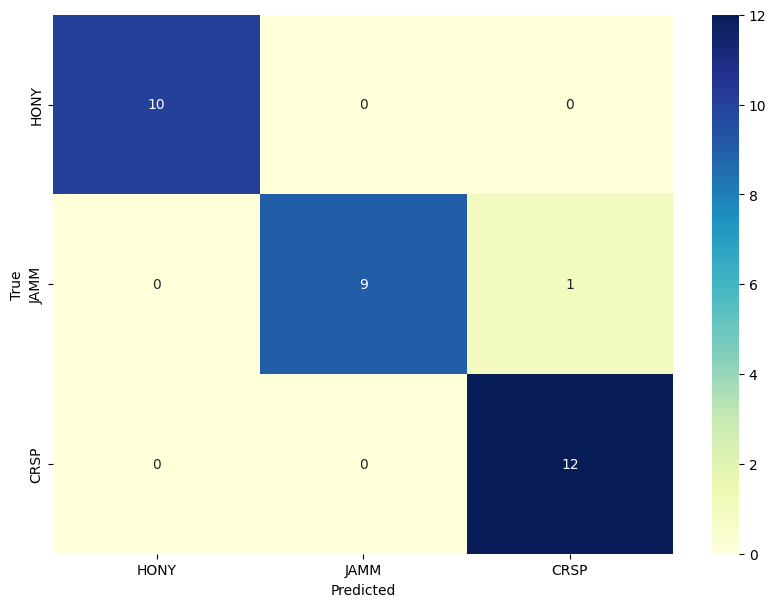

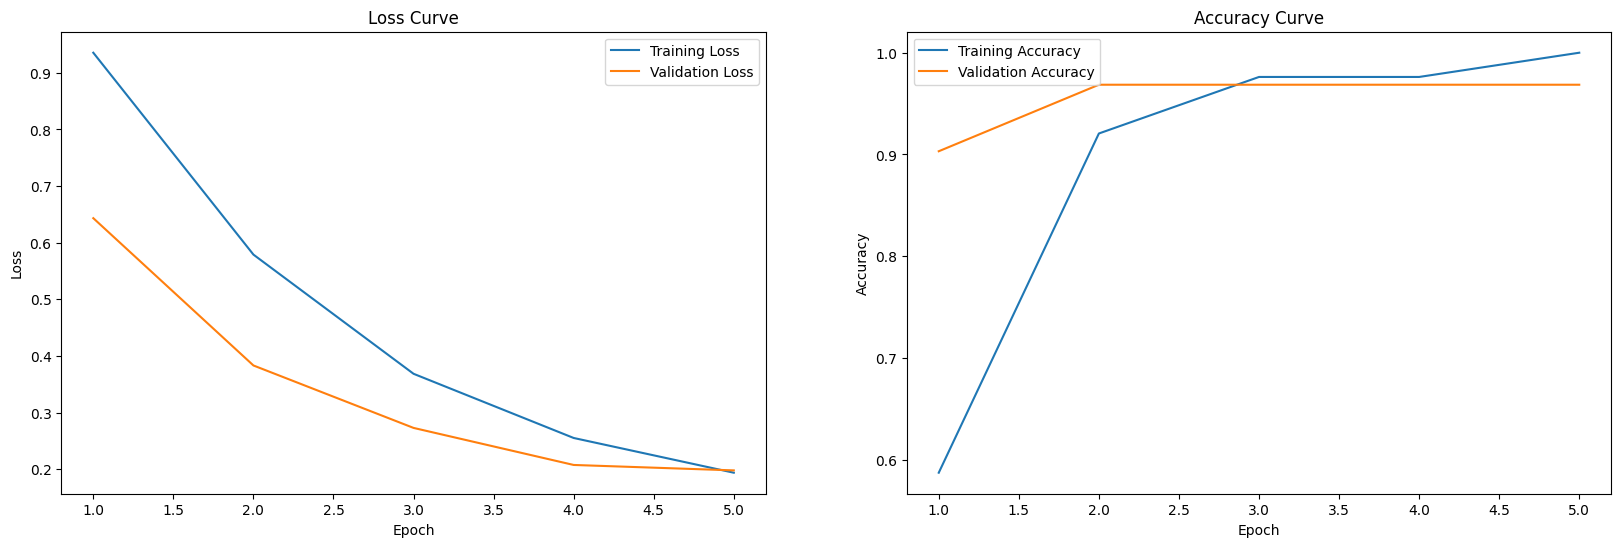

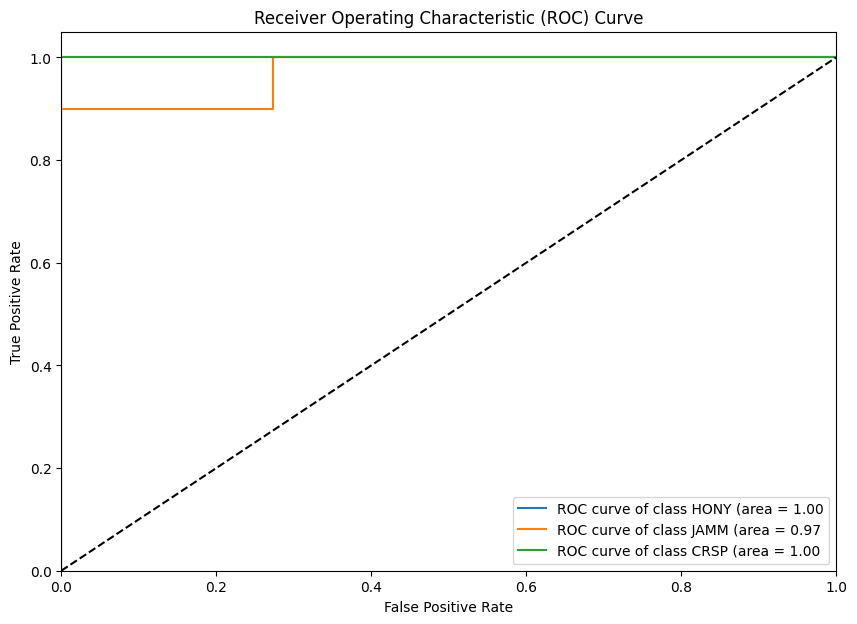

Opening Dataset of Model: DAIR Classifier
Cleaning Dataset of Model: DAIR Classifier
Encoding Labels of Model: DAIR Classifier
{'CHCH': 0, 'EGGS': 1, 'SKML': 2, 'SFCH': 3, 'WHMK': 4}
Splitting Data of Model: DAIR Classifier
Tokenizing: DAIR Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: DAIR Classifier
Using device: cuda
Training of Model: DAIR Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.465033419430256
Validation loss: 1.1314940727674043
F1 Score (Weighted): 0.48924522608733134


Epoch 2:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.9949158187955618
Validation loss: 0.738859488413884
F1 Score (Weighted): 0.8558558558558559


Epoch 3:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.7184594850987196
Validation loss: 0.5237747258864917
F1 Score (Weighted): 0.9729052360631308


Epoch 4:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5492441036428014
Validation loss: 0.4124010583529106
F1 Score (Weighted): 0.9454492086071035


Epoch 5:   0%|          | 0/48 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.4474801275258263
Validation loss: 0.37629989133431363
F1 Score (Weighted): 0.9454492086071035
Testing Model: DAIR Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: CHCH
Accuracy: 9/10

Class: EGGS
Accuracy: 9/9

Class: SKML
Accuracy: 4/4

Class: SFCH
Accuracy: 10/10

Class: WHMK
Accuracy: 3/4



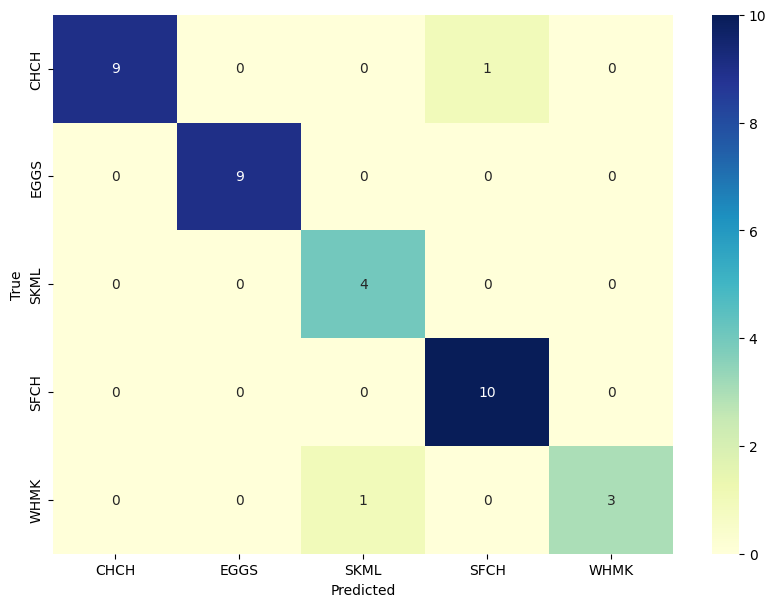

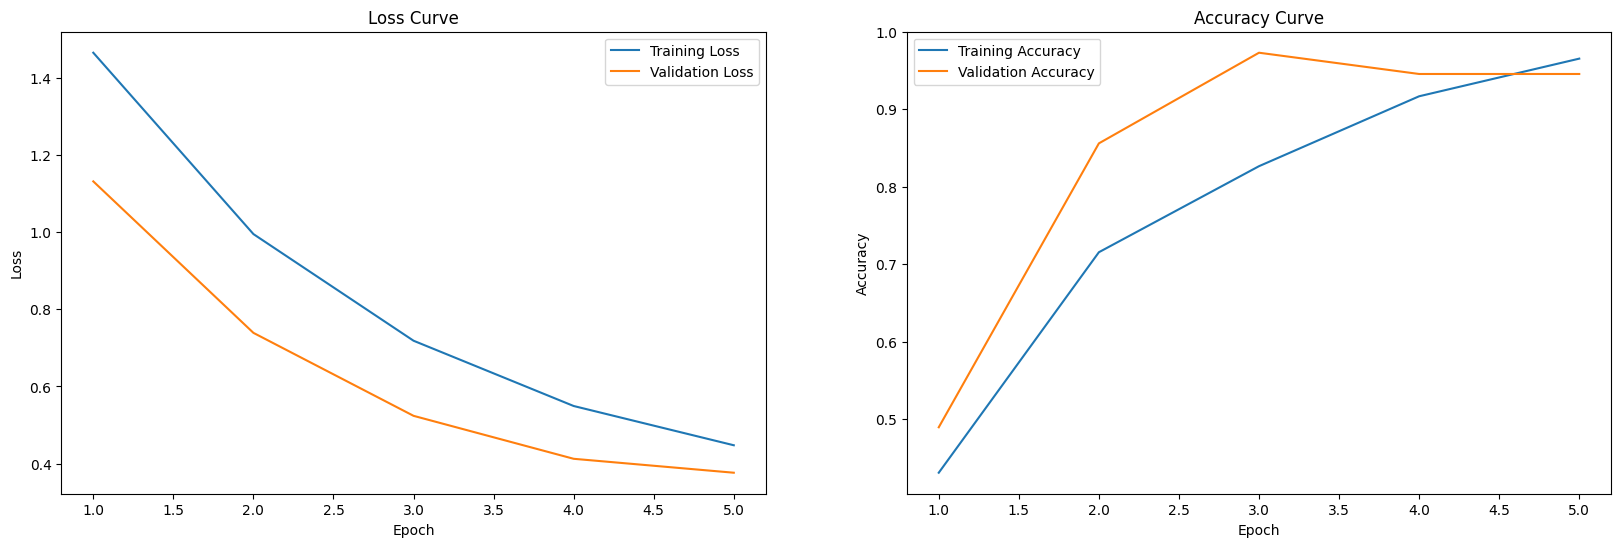

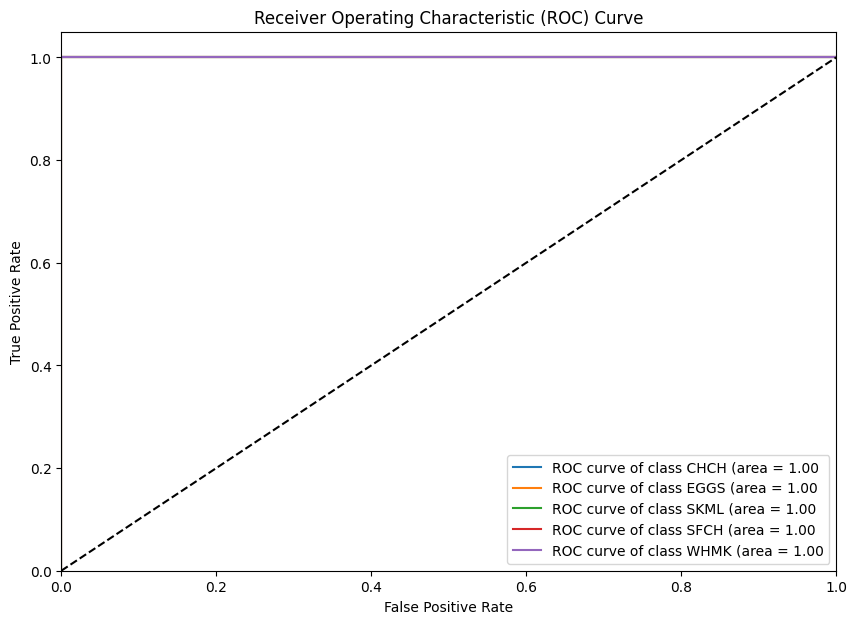

Opening Dataset of Model: FISH Classifier
Cleaning Dataset of Model: FISH Classifier
Encoding Labels of Model: FISH Classifier
{'FSFF': 0, 'FWFF': 1, 'PRAW': 2}
Splitting Data of Model: FISH Classifier
Tokenizing: FISH Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: FISH Classifier
Using device: cuda
Training of Model: FISH Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.1394782223199542
Validation loss: 1.0040362358093262
F1 Score (Weighted): 0.3756613756613757


Epoch 2:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.9866653304351004
Validation loss: 0.8524619221687317
F1 Score (Weighted): 0.7712842712842712


Epoch 3:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.8173586506592599
Validation loss: 0.6871774077415467
F1 Score (Weighted): 0.861111111111111


Epoch 4:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.7384166043055685
Validation loss: 0.6142876505851745
F1 Score (Weighted): 0.9326599326599326


Epoch 5:   0%|          | 0/19 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.66283602149863
Validation loss: 0.590170395374298
F1 Score (Weighted): 0.861111111111111
Testing Model: FISH Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: FSFF
Accuracy: 5/5

Class: FWFF
Accuracy: 4/5

Class: PRAW
Accuracy: 5/5



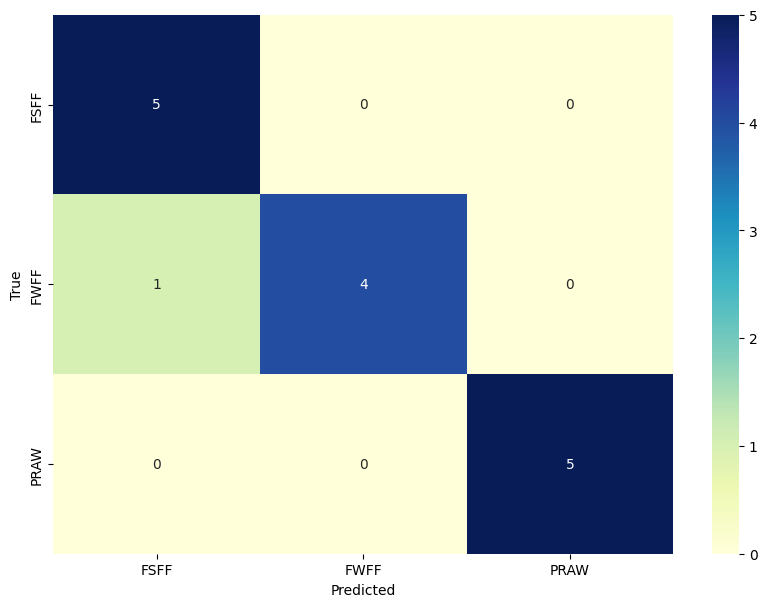

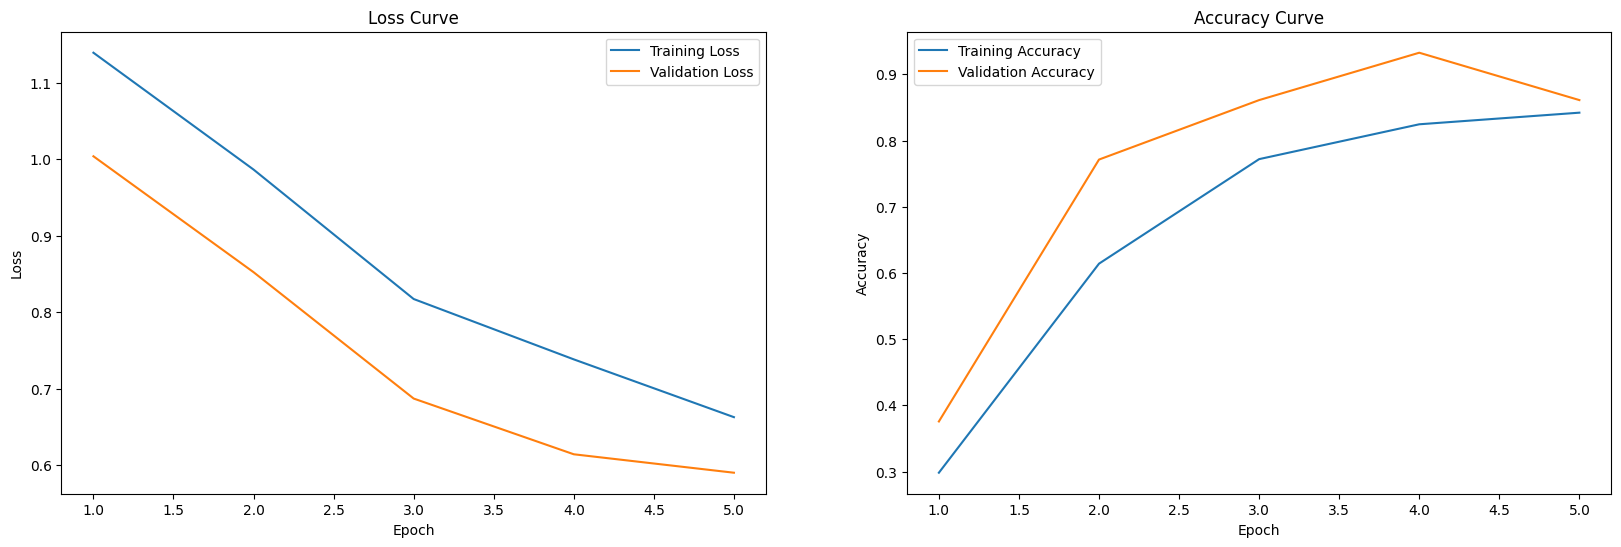

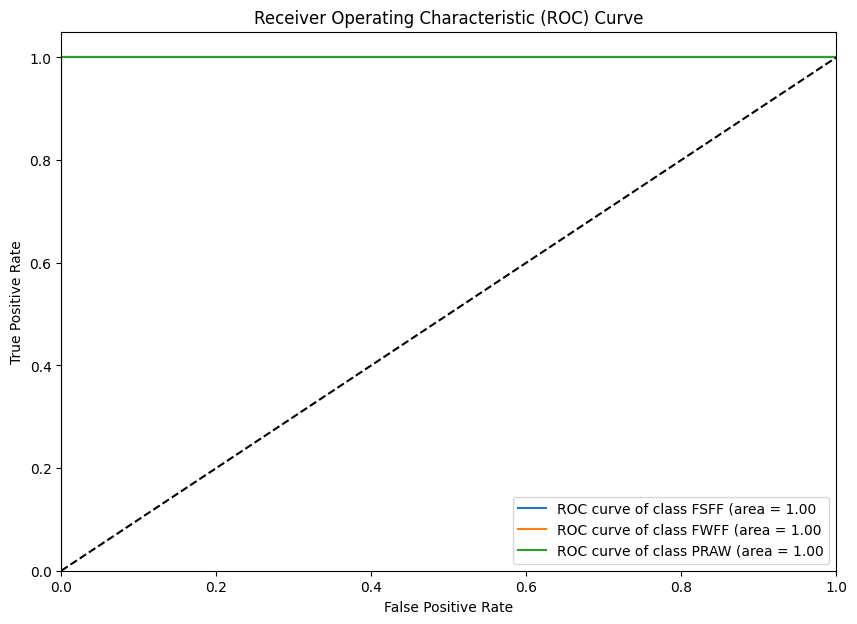

Opening Dataset of Model: MEAT Classifier
Cleaning Dataset of Model: MEAT Classifier
Encoding Labels of Model: MEAT Classifier
{'PORK': 0, 'BEEF': 1, 'CHCK': 2, 'TURK': 3}
Splitting Data of Model: MEAT Classifier
Tokenizing: MEAT Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: MEAT Classifier
Using device: cuda
Training of Model: MEAT Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.2324013537830776
Validation loss: 0.9581987935563793
F1 Score (Weighted): 0.7824847016250968


Epoch 2:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7277608820133739
Validation loss: 0.5303283119979112
F1 Score (Weighted): 0.7964029158059008


Epoch 3:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.41528868931863044
Validation loss: 0.3235145324598188
F1 Score (Weighted): 0.9023680049365576


Epoch 4:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.2390151107062896
Validation loss: 0.24703143504650696
F1 Score (Weighted): 0.9538420852547891


Epoch 5:   0%|          | 0/90 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.1818739908023013
Validation loss: 0.22094994904878346
F1 Score (Weighted): 0.9538420852547891
Testing Model: MEAT Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: PORK
Accuracy: 17/17

Class: BEEF
Accuracy: 21/22

Class: CHCK
Accuracy: 20/20

Class: TURK
Accuracy: 6/8



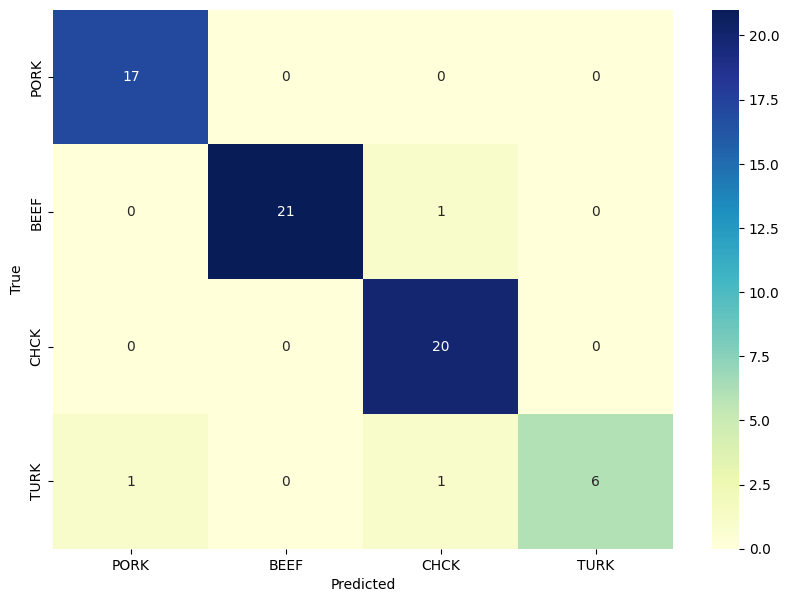

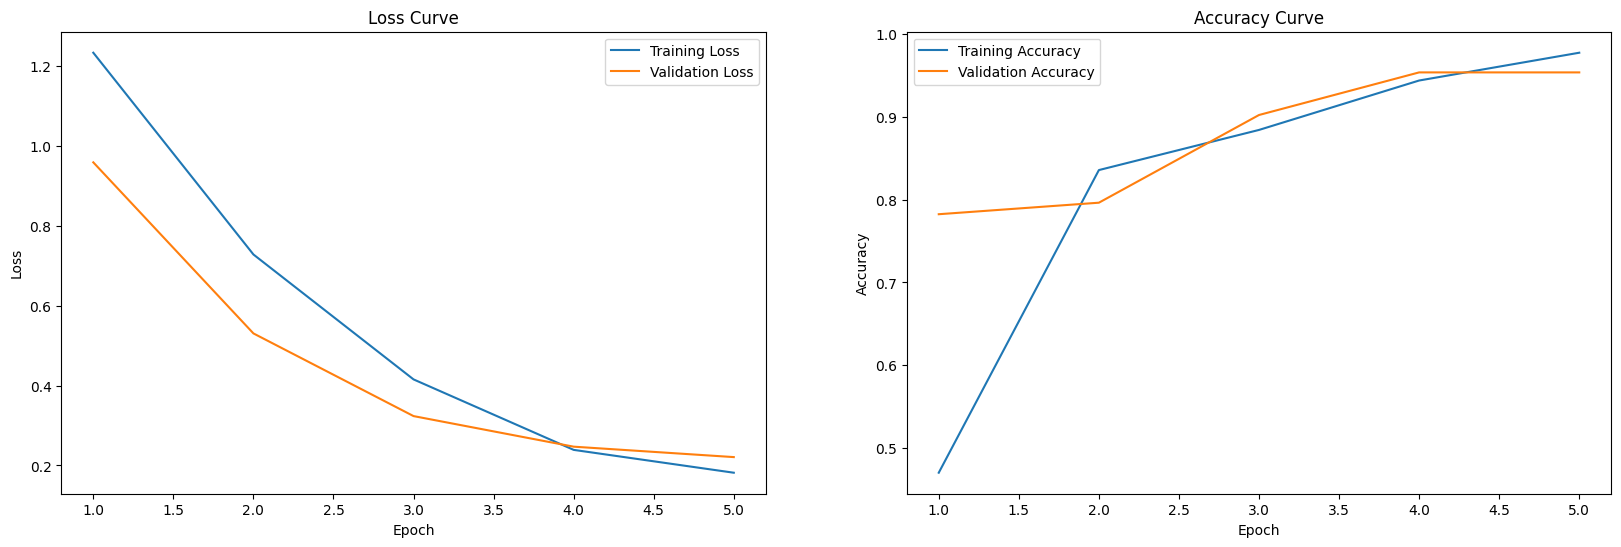

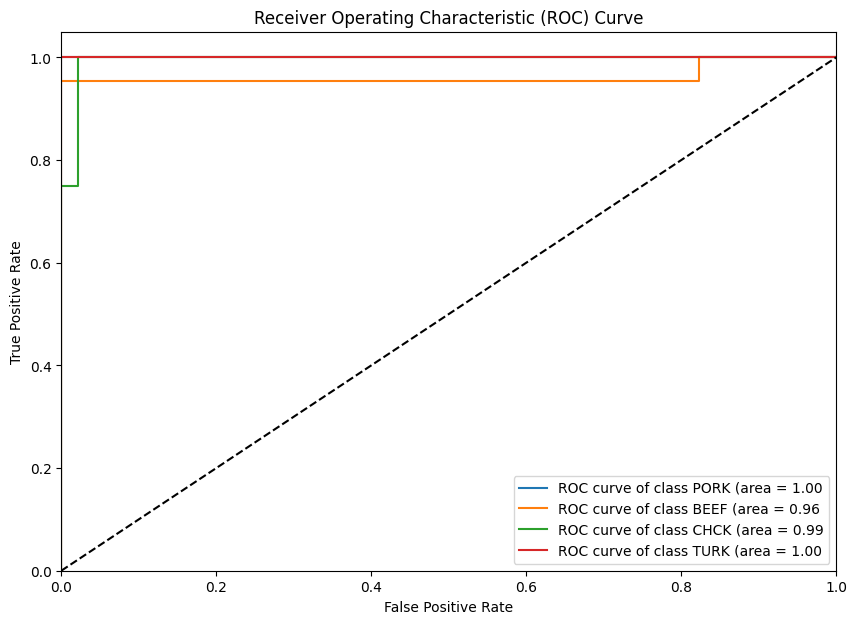

Opening Dataset of Model: FRFR Classifier
Cleaning Dataset of Model: FRFR Classifier
Encoding Labels of Model: FRFR Classifier
{'AVOC': 0, 'BANA': 1, 'BLUE': 2, 'APPL': 3, 'GRAP': 4, 'KIWI': 5, 'LEMN': 6, 'ORNG': 7, 'PINE': 8, 'PLUM': 9, 'RASP': 10}
Splitting Data of Model: FRFR Classifier
Tokenizing: FRFR Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: FRFR Classifier
Using device: cuda
Training of Model: FRFR Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.1892436199849197
Validation loss: 1.8738504235561078
F1 Score (Weighted): 0.4683070076376713


Epoch 2:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.690997846055739
Validation loss: 1.4364652129319997
F1 Score (Weighted): 0.8373015873015873


Epoch 3:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.332217308554319
Validation loss: 1.111480570756472
F1 Score (Weighted): 0.9475076855511637


Epoch 4:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.0729063259493006
Validation loss: 0.8942642991359417
F1 Score (Weighted): 0.9736115216965512


Epoch 5:   0%|          | 0/101 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.9389331848314493
Validation loss: 0.8309026956558228
F1 Score (Weighted): 0.9736115216965512
Testing Model: FRFR Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: AVOC
Accuracy: 10/10

Class: BANA
Accuracy: 7/7

Class: BLUE
Accuracy: 7/7

Class: APPL
Accuracy: 11/12

Class: GRAP
Accuracy: 9/9

Class: KIWI
Accuracy: 6/6

Class: LEMN
Accuracy: 5/5

Class: ORNG
Accuracy: 4/5

Class: PINE
Accuracy: 5/5

Class: PLUM
Accuracy: 5/5

Class: RASP
Accuracy: 5/5



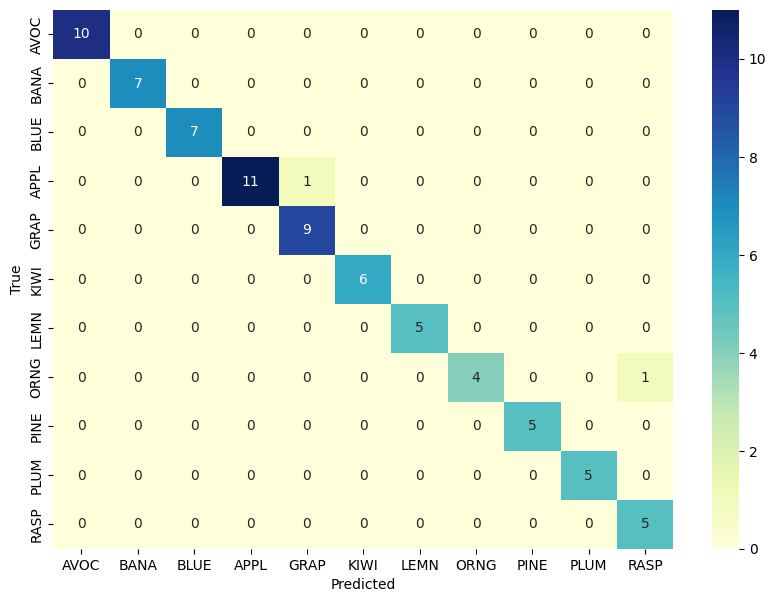

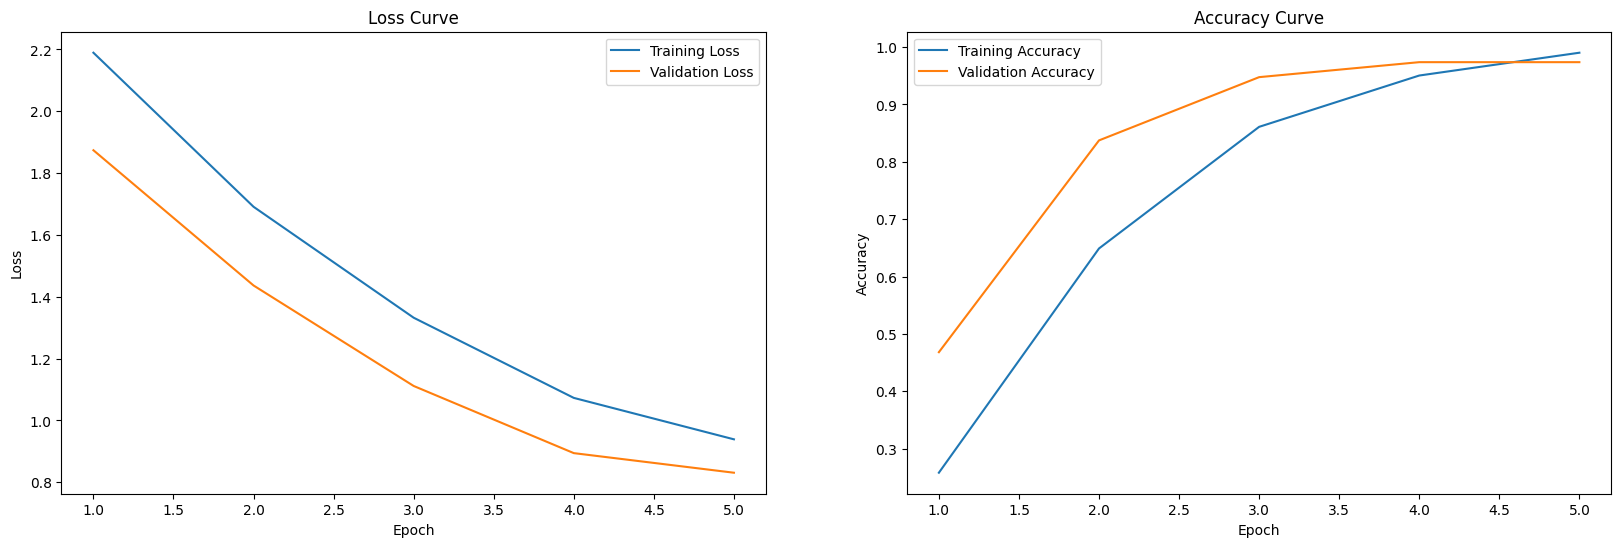

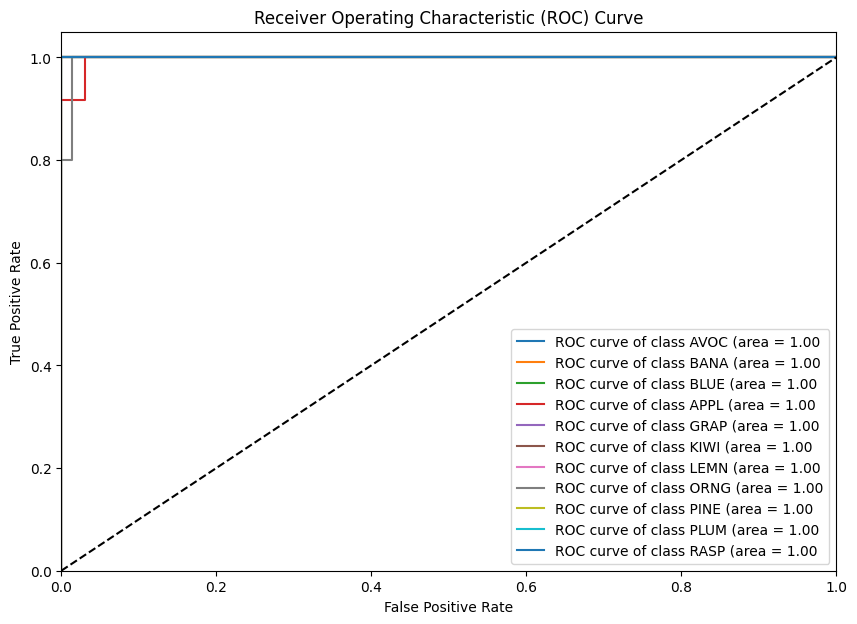

Opening Dataset of Model: FRVG Classifier
Cleaning Dataset of Model: FRVG Classifier
Encoding Labels of Model: FRVG Classifier
{'BROC': 0, 'CARR': 1, 'CAUL': 2, 'CUCU': 3, 'LETT': 4, 'MUSH': 5, 'ONIO': 6, 'PEPP': 7, 'TOMA': 8, 'MXVG': 9}
Splitting Data of Model: FRVG Classifier
Tokenizing: FRVG Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: FRVG Classifier
Using device: cuda
Training of Model: FRVG Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/72 [00:00<?, ?it/s]


Epoch 1
Training loss: 2.234502100282245
Validation loss: 1.9606131381458707
F1 Score (Weighted): 0.4042755598311154


Epoch 2:   0%|          | 0/72 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.8194322635730107
Validation loss: 1.5045084092352126
F1 Score (Weighted): 0.7582930867244592


Epoch 3:   0%|          | 0/72 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.4160027007261913
Validation loss: 1.1879628433121576
F1 Score (Weighted): 0.9209150326797386


Epoch 4:   0%|          | 0/72 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.1912918272945616
Validation loss: 1.007813082800971
F1 Score (Weighted): 0.9207886763442319


Epoch 5:   0%|          | 0/72 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.065347941385375
Validation loss: 0.9408165779378679
F1 Score (Weighted): 0.961773351315835
Testing Model: FRVG Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: BROC
Accuracy: 8/8

Class: CARR
Accuracy: 7/7

Class: CAUL
Accuracy: 3/4

Class: CUCU
Accuracy: 5/5

Class: LETT
Accuracy: 4/5

Class: MUSH
Accuracy: 6/6

Class: ONIO
Accuracy: 5/5

Class: PEPP
Accuracy: 2/4

Class: TOMA
Accuracy: 6/6

Class: MXVG
Accuracy: 4/4



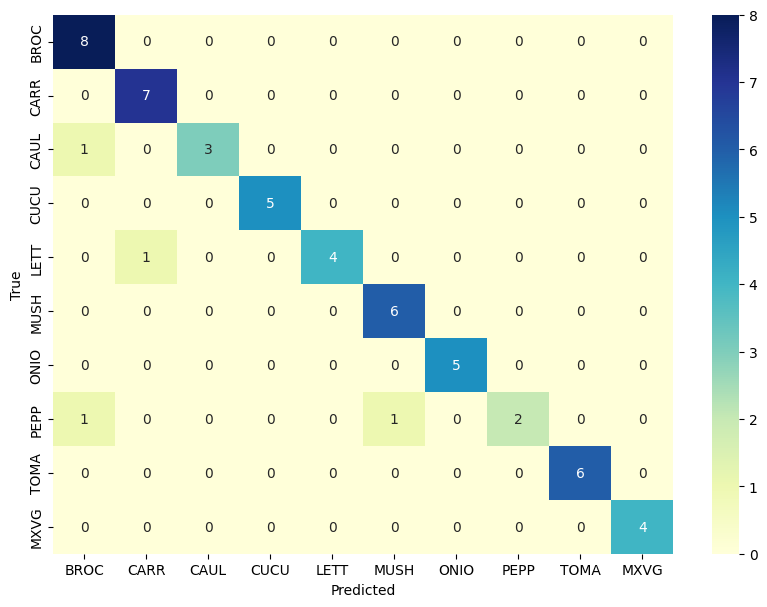

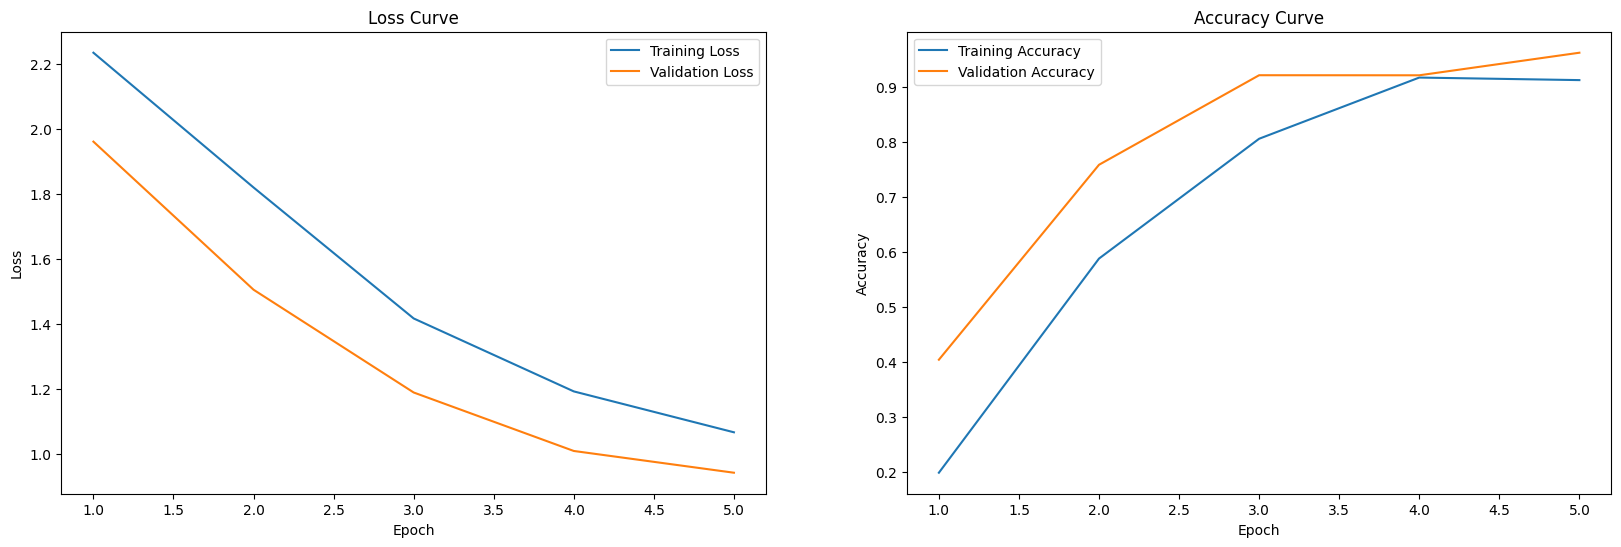

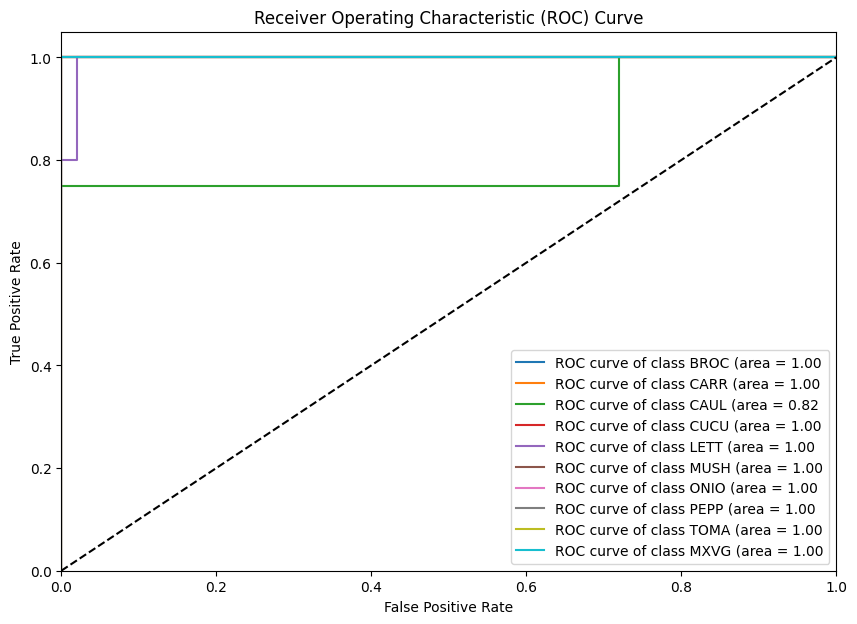

Opening Dataset of Model: POTA Classifier
Cleaning Dataset of Model: POTA Classifier
Encoding Labels of Model: POTA Classifier
{'POTT': 0, 'SWPT': 1}
Splitting Data of Model: POTA Classifier
Tokenizing: POTA Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: POTA Classifier
Using device: cuda
Training of Model: POTA Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6859815150499344
Validation loss: 0.6772196541229883
F1 Score (Weighted): 0.4807692307692308


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5839300930500031
Validation loss: 0.5845855673154196
F1 Score (Weighted): 0.4807692307692308


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5372385054826736
Validation loss: 0.5431708296140035
F1 Score (Weighted): 0.4807692307692308


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.46445700377225874
Validation loss: 0.5030143956343333
F1 Score (Weighted): 0.7083333333333333


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.4577093288302422
Validation loss: 0.4866062601407369
F1 Score (Weighted): 0.7083333333333333
Testing Model: POTA Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: POTT
Accuracy: 5/5

Class: SWPT
Accuracy: 1/3



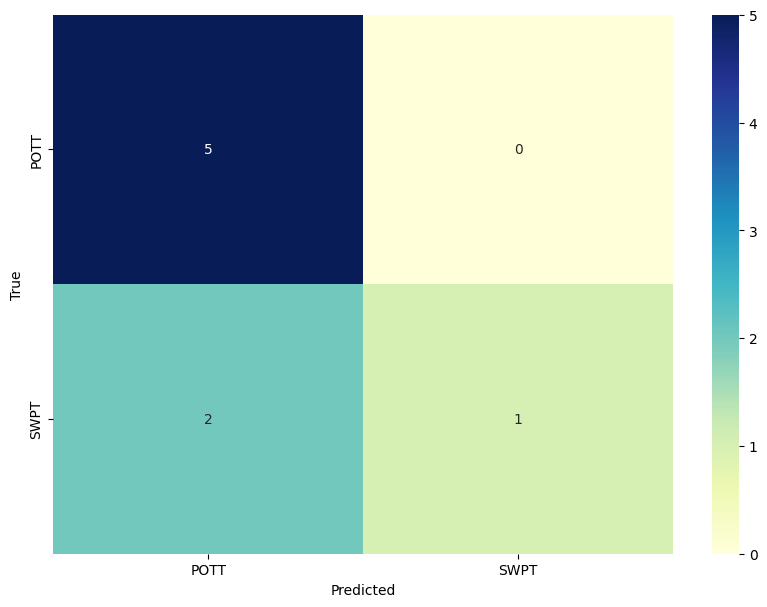

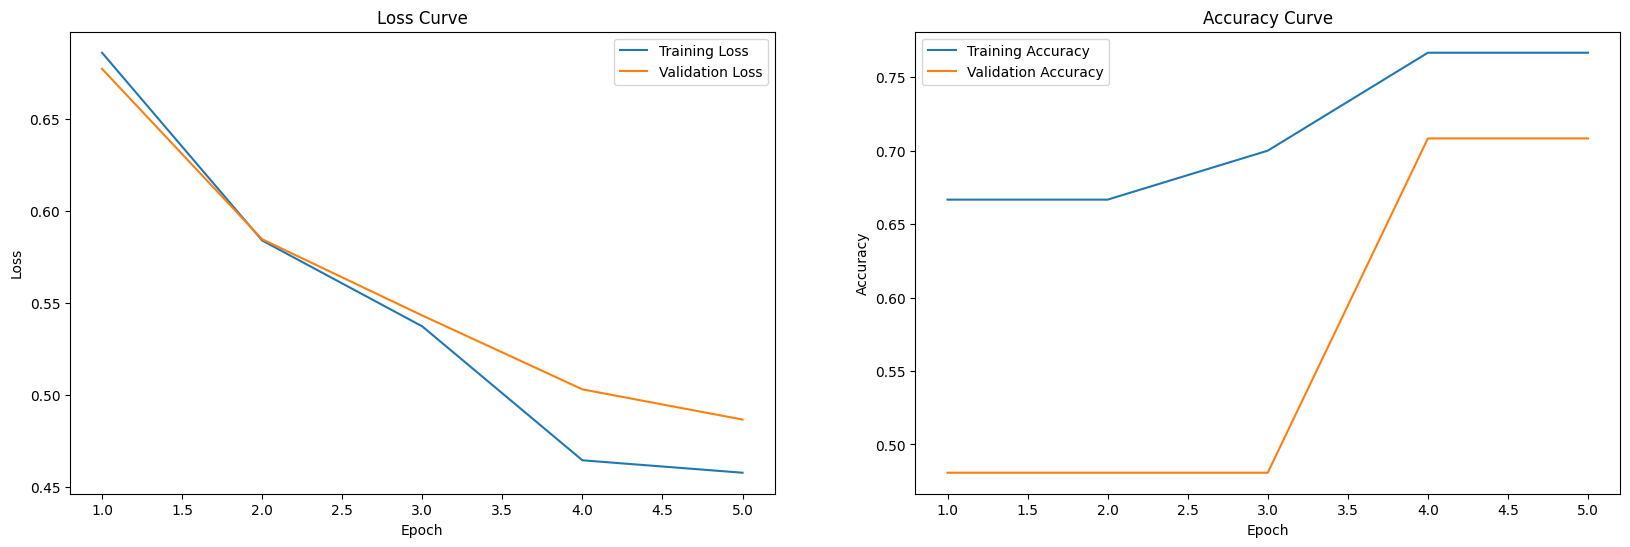

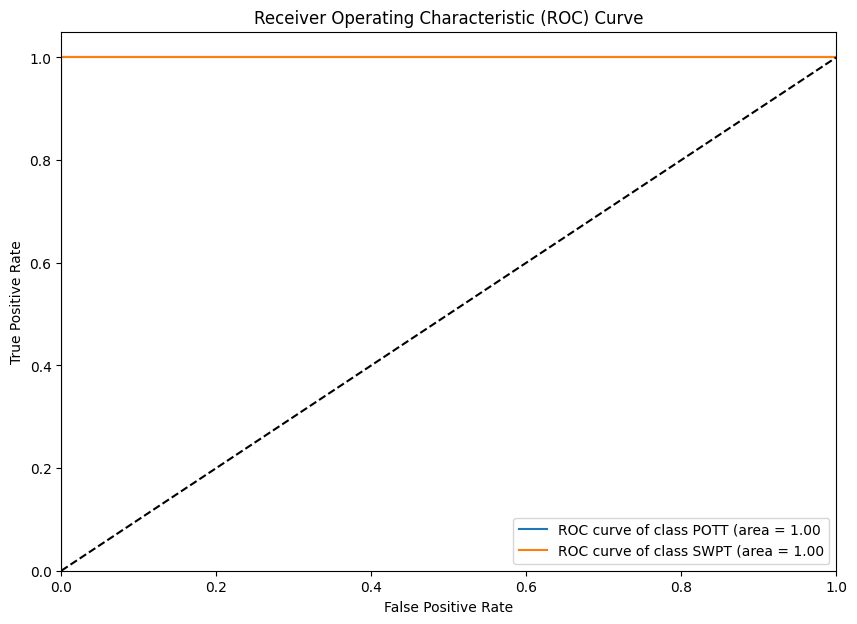

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: BRKF Classifier
Cleaning Dataset of Model: BRKF Classifier
Encoding Labels of Model: BRKF Classifier
{'BCGF': 0, 'BCER': 1}
Splitting Data of Model: BRKF Classifier
Tokenizing: BRKF Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceCla

Loading Data of Model: BRKF Classifier
Using device: cuda
Training of Model: BRKF Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.6302401636328016
Validation loss: 0.5039818932612737
F1 Score (Weighted): 0.938259109311741


Epoch 2:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.414081274043946
Validation loss: 0.34340691814819974
F1 Score (Weighted): 0.938259109311741


Epoch 3:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.26685241219543276
Validation loss: 0.237752765417099
F1 Score (Weighted): 0.938259109311741


Epoch 4:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.17831562069200335
Validation loss: 0.2034077843030294
F1 Score (Weighted): 0.938259109311741


Epoch 5:   0%|          | 0/21 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.1465817072561809
Validation loss: 0.18489577248692513
F1 Score (Weighted): 0.938259109311741
Testing Model: BRKF Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: BCGF
Accuracy: 6/6

Class: BCER
Accuracy: 9/10



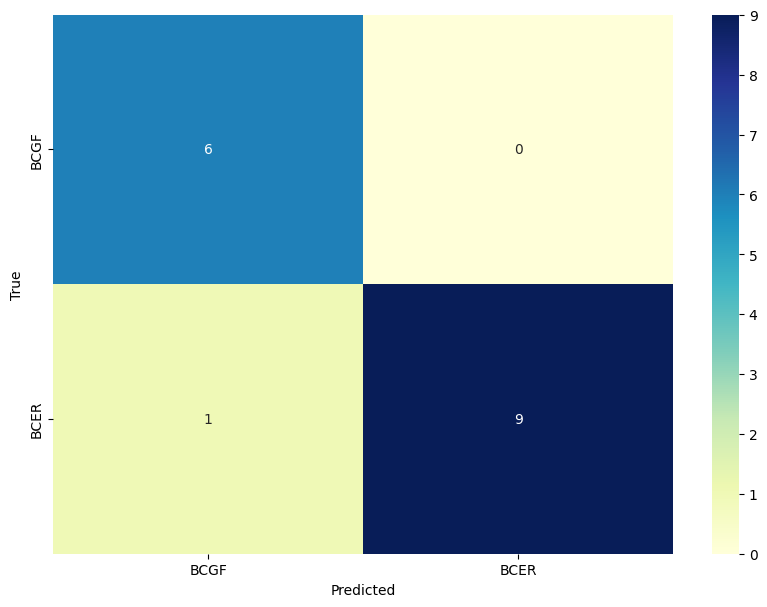

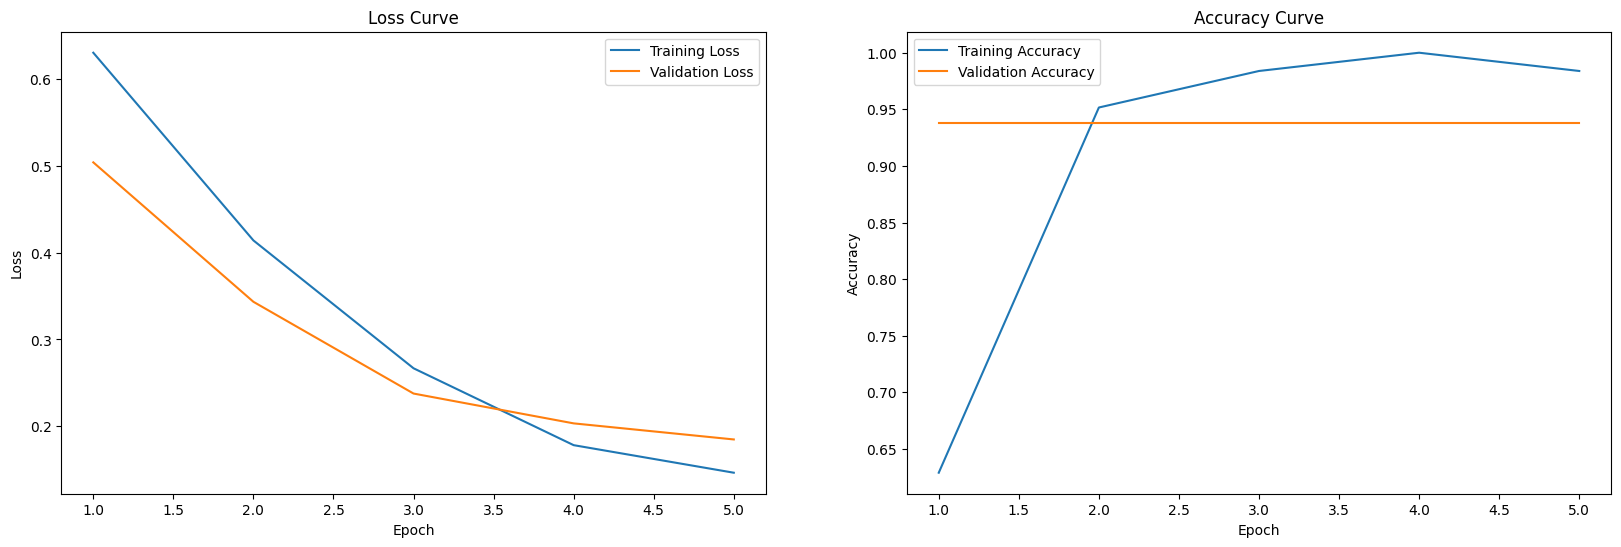

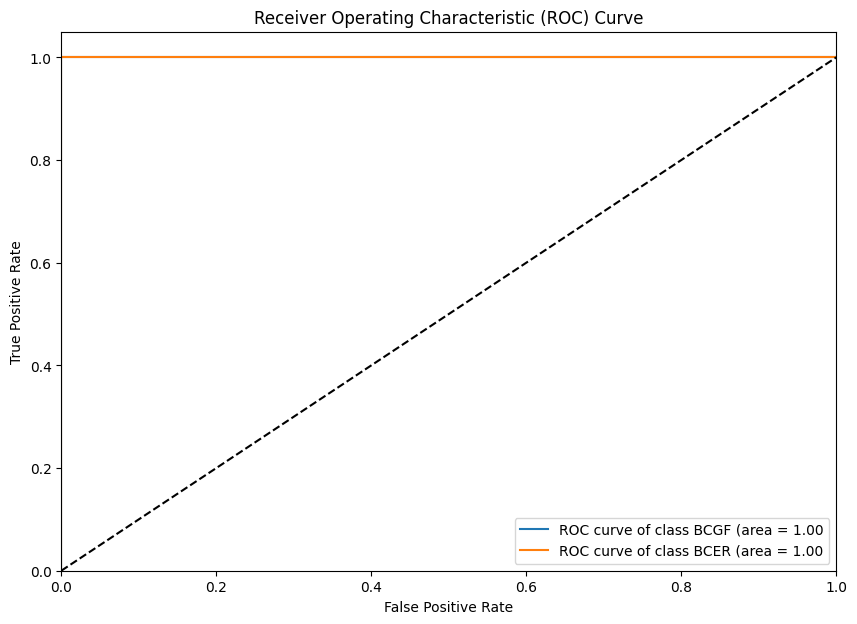

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: BSOI Classifier
Cleaning Dataset of Model: BSOI Classifier
Encoding Labels of Model: BSOI Classifier
{'BUTT': 0, 'MARG': 1, 'OLOL': 2}
Splitting Data of Model: BSOI Classifier
Tokenizing: BSOI Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceCla

Loading Data of Model: BSOI Classifier
Using device: cuda
Training of Model: BSOI Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/37 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.941100682761218
Validation loss: 0.5957145124673844
F1 Score (Weighted): 1.0


Epoch 2:   0%|          | 0/37 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.4749728948683352
Validation loss: 0.2506161525845528
F1 Score (Weighted): 1.0


Epoch 3:   0%|          | 0/37 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.24935192695340594
Validation loss: 0.13571939021348953
F1 Score (Weighted): 1.0


Epoch 4:   0%|          | 0/37 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.15857403221968058
Validation loss: 0.09687157347798347
F1 Score (Weighted): 1.0


Epoch 5:   0%|          | 0/37 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.13084000671232068
Validation loss: 0.08469860702753067
F1 Score (Weighted): 1.0
Testing Model: BSOI Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: BUTT
Accuracy: 7/7

Class: MARG
Accuracy: 11/11

Class: OLOL
Accuracy: 10/10



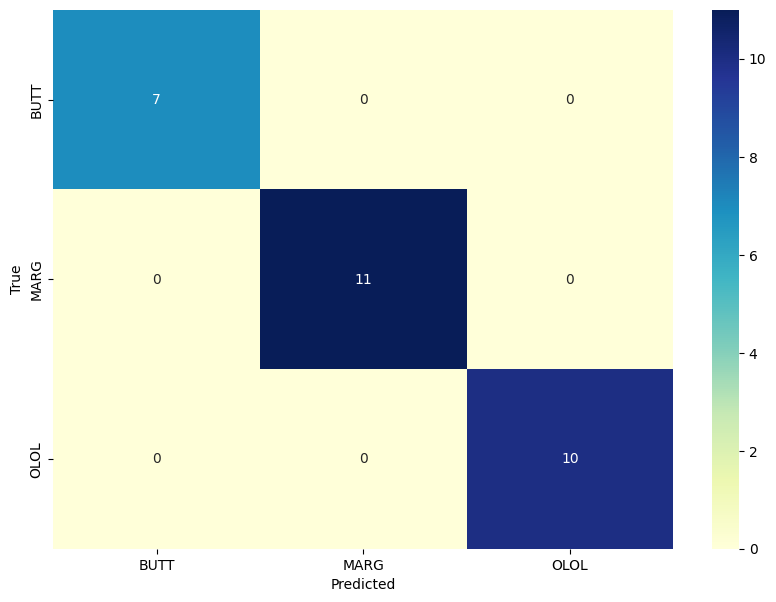

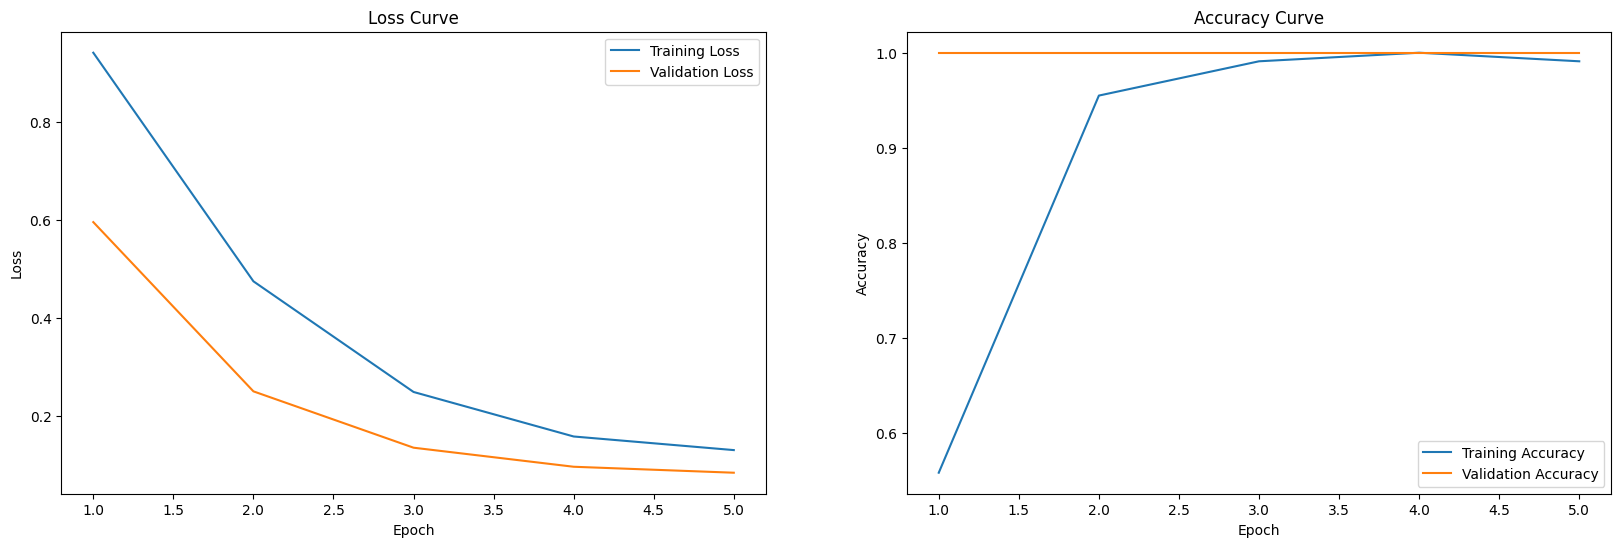

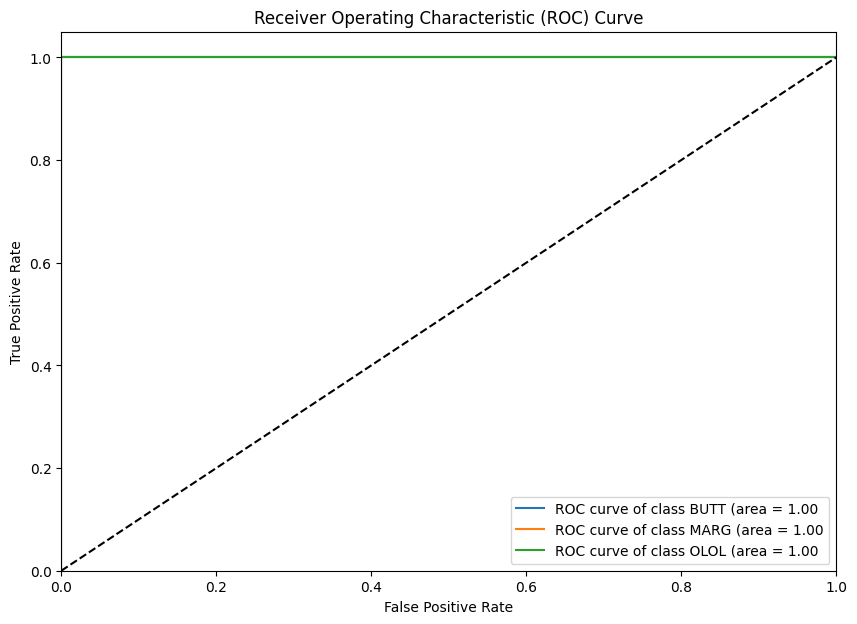

Opening Dataset of Model: CANF Classifier
Cleaning Dataset of Model: CANF Classifier
Encoding Labels of Model: CANF Classifier
{'CTUN': 0, 'BKBN': 1, 'CNFR': 2}
Splitting Data of Model: CANF Classifier
Tokenizing: CANF Classifier


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSeq

Loading Data of Model: CANF Classifier
Using device: cuda
Training of Model: CANF Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/29 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9511597382611242
Validation loss: 0.8303304687142372
F1 Score (Weighted): 0.701113701113701


Epoch 2:   0%|          | 0/29 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7176978649764225
Validation loss: 0.5786047242581844
F1 Score (Weighted): 0.9522868435911913


Epoch 3:   0%|          | 0/29 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5468846693121153
Validation loss: 0.3710612263530493
F1 Score (Weighted): 1.0


Epoch 4:   0%|          | 0/29 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.4044931361387516
Validation loss: 0.2699238024652004
F1 Score (Weighted): 1.0


Epoch 5:   0%|          | 0/29 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.360459473626367
Validation loss: 0.25159491691738367
F1 Score (Weighted): 1.0
Testing Model: CANF Classifier


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Class: CTUN
Accuracy: 7/7

Class: BKBN
Accuracy: 11/11

Class: CNFR
Accuracy: 4/4



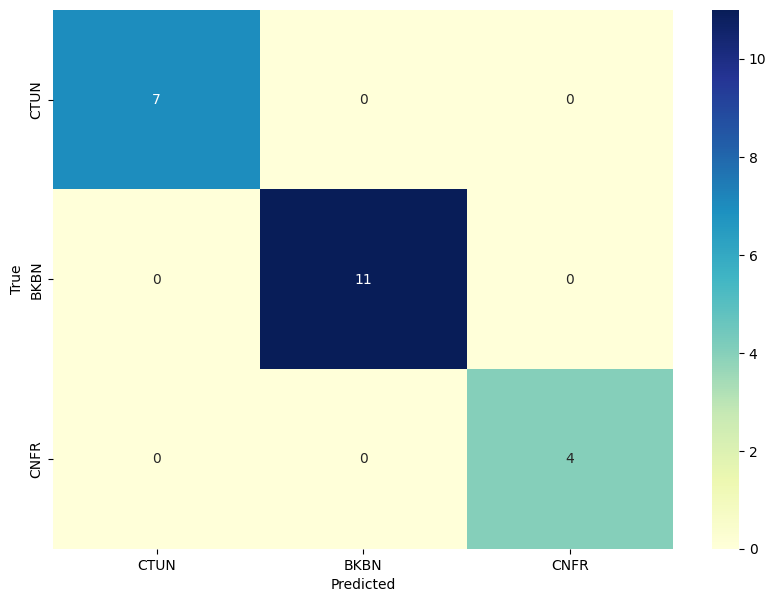

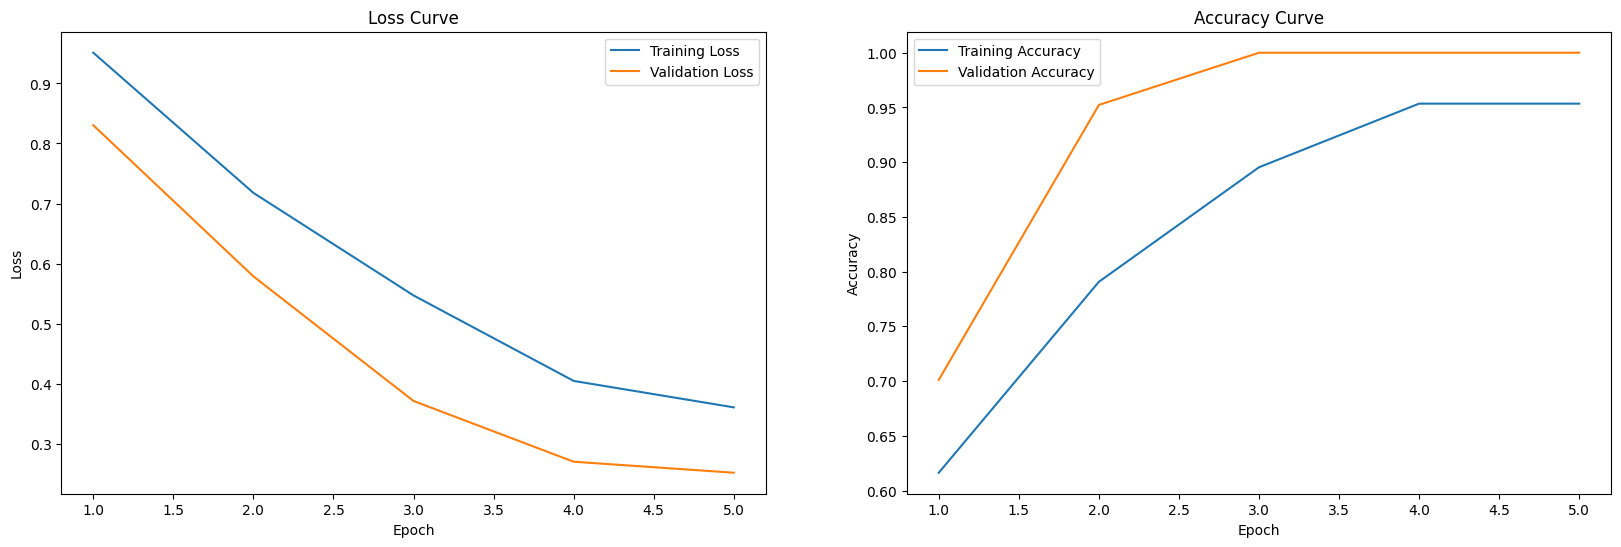

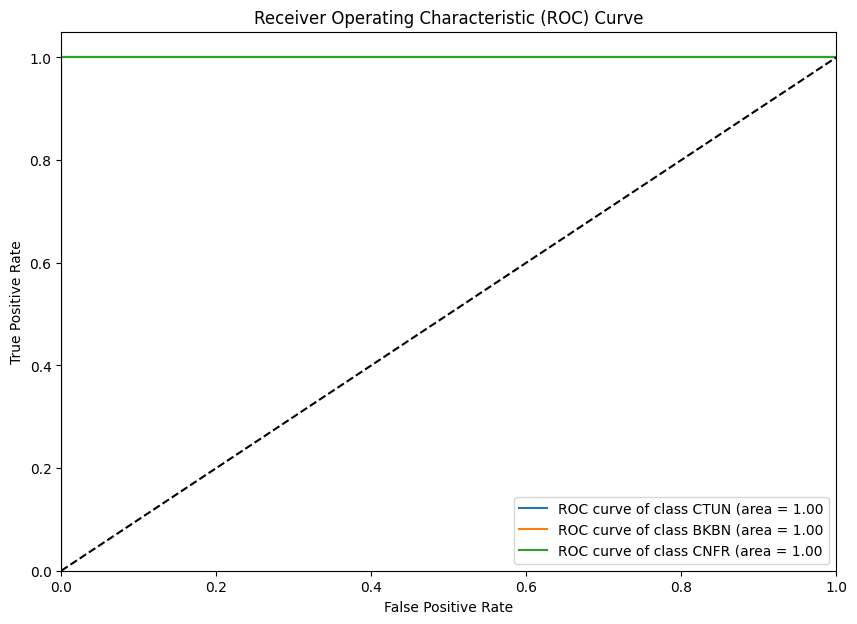

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Opening Dataset of Model: RICE Classifier
Cleaning Dataset of Model: RICE Classifier
Encoding Labels of Model: RICE Classifier
{'BSRX': 0, 'JSRX': 1, 'LGRX': 2}
Splitting Data of Model: RICE Classifier
Tokenizing: RICE Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceCla

Loading Data of Model: RICE Classifier
Using device: cuda
Training of Model: RICE Classifier


d:\anaconda3\envs\PP\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.9857850342988967
Validation loss: 0.8073251366615295
F1 Score (Weighted): 0.805458089668616


Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7895856857299804
Validation loss: 0.5713909804821015
F1 Score (Weighted): 0.805458089668616


Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5526120901107788
Validation loss: 0.43996405601501465
F1 Score (Weighted): 0.8133333333333332


Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\caffe2\serialize\inline_container.cc:337] . unexpected pos 47296 vs 47184

In [16]:
COLS = ["CATEGORY", "NAME"]
# Original LR = 1e-5
EPOCHS = 5
BATCH_SIZE = 3
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 0.001
GRADIENT_CLIPPING = 0.5
DROPOUT_RATE = 0.1
# Model 1: Food or Beverage  
torch.cuda.empty_cache()
model_trainer(
    DATA_SET_PATH='../Data/food_bevCAT.csv',
    SAVE_PATH='models/food_beverage_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="Food And Beverage Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()


# Food Model 1: FDAA Type (Food Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/FDAACat.csv',
    SAVE_PATH='models/fdaa_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="FDAA Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()


# Beverage Model 1: BEVA Type (Beverage Type)
model_trainer(
    DATA_SET_PATH='../Data/Beverage/BEVACat.csv',
    SAVE_PATH='models/beva_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="BEVA Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()


# Beverage Sub Category Models

## BEVA Model 1: SODR Type (Soft Drinks Type)
model_trainer(
    DATA_SET_PATH='../Data/Beverage/SODRCat.csv',
    SAVE_PATH='models/sodr_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="SODR Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

## BEVA Model 2: WATR Type (Water Type)
model_trainer(
    DATA_SET_PATH='../Data/Beverage/WATRCat.csv',
    SAVE_PATH='models/watr_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="WATR Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# BEVA Model 3: CTCC Type (Coffe, tea, Cocoa Type)
model_trainer(
    DATA_SET_PATH='../Data/Beverage/CTCCCat.csv',
    SAVE_PATH='models/ctcc_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="CTCC Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()


# Food Sub Categories
# Food Model 1: BAKA Type (Baking Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/BAKACat.csv',
    SAVE_PATH='models/baka_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="BAKA Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# Food Model 2: MISC Type (Misc Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/MISCCat.csv',
    SAVE_PATH='models/misc_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="MISC Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()


# Food Model 3: ANIP Type (Animal Products Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/ANIPCat.csv',
    SAVE_PATH='models/anip_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="ANIP Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# Food Model 4: FRTV Type (Fruit and Vegetable Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/FRTVCat.csv',
    SAVE_PATH='models/frtv_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="FRTV Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# Food Model 5: CUFD Type (Cuboard Food Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/CUFDCat.csv',
    SAVE_PATH='models/cufd_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="CUFD Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# BAKA Sub Categories
## BAKA Model 1: BAKY Type (Bakery Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/BAKYCat.csv',
    SAVE_PATH='models/baky_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="BAKY Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

## BAKA Model 2: BKGD Type (Baking Goods Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/BKGDCat.csv',
    SAVE_PATH='models/bkgd_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="BKGD Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# MISC Sub Categories
### MISC Model 1: CHSW Type (Chocolate and Sweets Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/CHSWCat.csv',
    SAVE_PATH='models/chsw_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="CHSW Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### MISC Model 2: JAMH Type (Jams, Marmalades, Honey Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/JAMHCat.csv',
    SAVE_PATH='models/jamh_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="JAMH Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# ANIP Sub Categories
### ANIP Model 1: DAIR Type (Dairy Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/DAIRCat.csv',
    SAVE_PATH='models/dair_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="DAIR Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### ANIP Model 2: FISH Type (Fish Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/FISHCat.csv',
    SAVE_PATH='models/fish_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="FISH Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### ANIP Model 3: MEAT Type (Meat Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/MEATCat.csv',
    SAVE_PATH='models/meat_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="MEAT Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# FRTV Sub Categories
### FRTV Model 1: FRFR Type (Fresh Fruit Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/FRFRCat.csv',
    SAVE_PATH='models/frfr_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="FRFR Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### FRTV Model 2: FRVG Type (Fresh Veg Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/FRVGCat.csv',
    SAVE_PATH='models/frvg_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="FRVG Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### FRTV Model 3: POTA Type (Potatoe Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/POTACat.csv',
    SAVE_PATH='models/pota_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="POTA Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

# CUFD Sub Categories
### CUFD Model 1: BRKF Type (Breakfast Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/BRKFCat.csv',
    SAVE_PATH='models/brkf_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="BRKF Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### CUFD Model 2: BSOI Type (Butter, Spreads and Oils Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/BSOICat.csv',
    SAVE_PATH='models/bsoi_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="BSOI Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### CUFD Model 3: CANF Type (Canned Food Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/CANFCat.csv',
    SAVE_PATH='models/canf_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="CANF Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

### CUFD Model 4: RICE Type (Rice Type)
model_trainer(
    DATA_SET_PATH='../Data/Food/RICECat.csv',
    SAVE_PATH='models/rice_models',
    COLS=COLS,
    EPOCHS=EPOCHS,
    BATCH_SIZE=BATCH_SIZE,
    MODEL_NAME="RICE Classifier",
    LEARNING_RATE=LEARNING_RATE,
    WEIGHT_DECAY=WEIGHT_DECAY,
    GRADIENT_CLIPPING=GRADIENT_CLIPPING,
    DROPOUT_RATE=DROPOUT_RATE,
)
torch.cuda.empty_cache()

